In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
import math


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import re

import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import auth
from google.auth import default

from scipy.optimize import curve_fit
import itertools


In [4]:
# Parameters
T = 24 #Duration of each day
delta = 0.2
S0 = 2
B0=1e8

## Define default parameters based on the table values
#cy = 1.01053e9
#cx = 1.1053e9
#Vmx = 8.7129e-10
#Kmx=1
betax = 2e-10
#Kmy=1
#Vmy = 8.27129e-10
#betay = 1e-10

Kix=1e11
#Kiy=1e11


strain_colors = ["#177E89", "#FFC857",  "#FF6B6B",  "#90BE6D", "#00A6A6", "#FF9F1C", "#7A9E7E"]


strain_lbls=['trpC', 'metA', 'ilvA', 'thrC', 'tyrA'] #, 'pheA', 'tyrA'
X_values = [0, 1, 2, 3, 4, 8]
X_values = [8]

sheet_url = 'https://docs.google.com/spreadsheets/d/1gop5K6NQsGI5mKA-cxuEx-CuQbaWnsoeCYPiI1mlH7k/edit?usp=sharing'



## Data fitting

In [5]:

def CFUs(ODs):
    b1 = 1002614811.71
    b2 = 12526559.79
    return b1 * ODs + b2

def Monod(y, t, rho, muK):
    R, B = y
    this_K = 1.0
    m = muK * this_K
    dydt = [-m * R / (this_K + R) * B, rho * m * R / (this_K + R) * B]
    return dydt

def simulate_model(rho, muK, y0, t):
    solution = odeint(Monod, y0, t, args=(rho, muK))
    R, B = solution.T
    return t, B

def plot_od_sim(df, strain, popt):
    """
    Plot the optical density data with error bars and overlay the model predictions.

    Parameters:
    - df: DataFrame containing the data.
    - strain: The strain name to use for labeling the data.
    - popt: Tuple of fitted parameters (rho, muK).
    """
    # Extract experimental data
    time = df['Time']

    mean_od = df[strain + ' MeanOD']
    std_od = df[strain + ' StdOD']


    # Calculate the standard error of the mean (SEM)
    sample_size = 3  # Adjust this if you have a different number of replicates
    sem = std_od / np.sqrt(sample_size)

    # Simulate the model with the optimized parameters
    initial_conditions = [1.0, mean_od.iloc[0]]  # Assuming some initial resource and the initial OD from your data
    simulated_t, simulated_B = simulate_model(*popt, initial_conditions, time.values)

    # Create the plot
    plt.figure(figsize=(6, 4))
    # Plot experimental data

    istrain = strain_lbls.index(strain[-4:])
    plt.errorbar(time, mean_od, yerr=sem, fmt=':',color=strain_colors[istrain], ecolor=strain_colors[istrain], capsize=2, label=f'{strain}')

    # Plot model predictions
    plt.plot(simulated_t, simulated_B, label='Model fit', linestyle='-', marker='', color=strain_colors[istrain], lw=3)

    plt.xlabel('Time (hours)')
    plt.ylabel('Density (cells/ml)')
    plt.title(f' {strain}')
    plt.legend()
    plt.grid(False)  # Optionally turn off the grid
    plt.show()



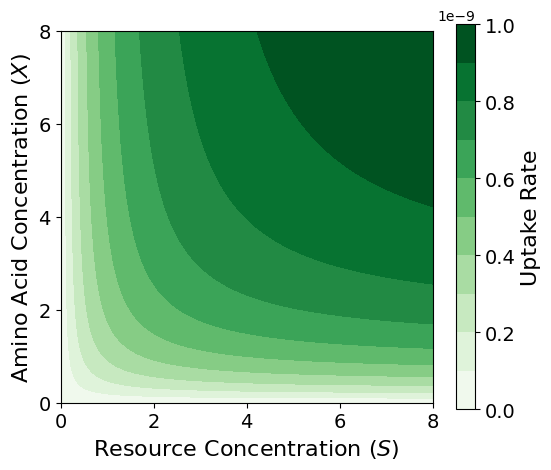

In [6]:


# Define the parameters of the model
Vm = 1.2526e-09  # Maximum uptake rate
Km = 1.  # Michaelis constant for resource
c = 8.2055e+08   # Efficiency coefficient
Aj_range = np.linspace(0, 8, 100)  # Amino acid concentration range
S_range = np.linspace(0, 8, 100)   # Resource concentration range

# Create a grid of amino acid and resource concentrations
Aj, S = np.meshgrid(Aj_range, S_range)

# Calculate the uptake rate for each combination of concentrations
U = Vm * S / (Km + S) * (Aj / (1 + Aj))

# Create a filled contour plot
plt.figure(figsize=(6,5))
contour = plt.contourf(S, Aj, U, levels=10, cmap='Greens')

# Add labels and title
plt.xlabel(r'Resource Concentration ($S$)', fontsize=16)
plt.ylabel(r'Amino Acid Concentration ($X$)', fontsize=16)
cbar = plt.colorbar(contour, label='Uptake Rate')
cbar.set_label('Uptake Rate', fontsize=16)
cbar.ax.tick_params(labelsize=14)


plt.xticks([0, 2, 4, 6 , 8],fontsize=14)
plt.yticks([0, 2, 4, 6, 8],fontsize=14)

# Show the plot
plt.grid(False)
plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal
plt.show()


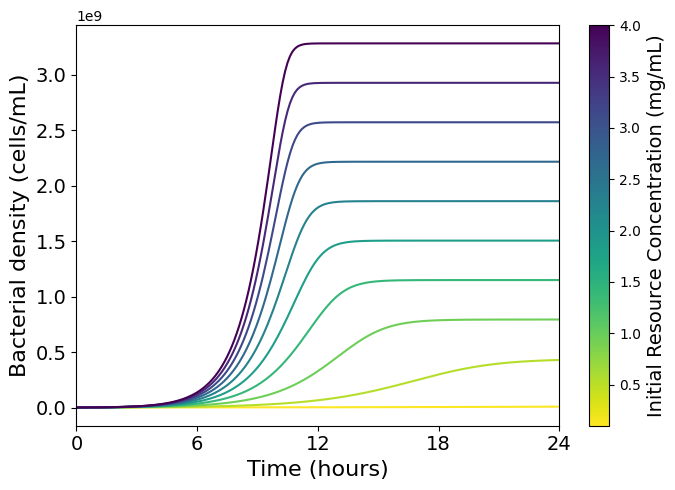

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.cm import viridis

t = np.linspace(0, 24, 200)

# --- Range of Initial Resources ---
initial_resources = np.linspace(0.1, 4.0, 10)  # 10 values from 0.1 to 4.0
initial_density = 1e6

# --- Color Mapping ---
cmap = plt.cm.viridis_r
norm = plt.Normalize(vmin=min(initial_resources), vmax=max(initial_resources))

# Create plot
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

for R0 in initial_resources:
    y0 = [R0, initial_density]
    sol = odeint(Monod, y0, t, args=(c, Vm))
    ax.plot(t, sol[:, 1], color=cmap(norm(R0)), label=f'R₀={R0:.1f}')

# Colorbar: use ax to tell matplotlib where to place it
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Initial Resource Concentration (mg/mL)', fontsize=14)

# Labels and Aesthetics
ax.set_xlabel('Time (hours)', fontsize=16)
ax.set_ylabel('Bacterial density (cells/mL)', fontsize=16)
ax.set_xticks([0, 6, 12, 18, 24])
ax.tick_params(labelsize=14)
ax.set_xlim([0, 24])
plt.tight_layout()
plt.show()

In [8]:

def load_data(sheet_url, tab_name, strain):
    # Authenticate and create the client
    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)

    # Open the worksheet by URL and get the specific tab by name
    sh = gc.open_by_url(sheet_url)
    worksheet = sh.worksheet(tab_name)  # Ensure tab name is correct

    # Get all the data from the sheet
    data = worksheet.get_all_values()

    # Convert to DataFrame
    headers = data[0]  # Assumes the first row is headers
    df = pd.DataFrame(data[1:], columns=headers)

    # Convert the first column to numeric for time, if it's the time column
    if 'Time' in df.columns:
        df['Time'] = pd.to_numeric(df['Time'], errors='coerce')

    # Filter columns by exact strain name match and convert them to numeric
    strain_columns = [col for col in df.columns if col.strip() == strain]

    if not strain_columns:
        print(f"No columns found for strain {strain}.")
        return None

    # Handle each column by its position to ensure uniqueness
    for i, col in enumerate(df.columns):
        if col.strip() == strain:
            df.iloc[:, i] = pd.to_numeric(df.iloc[:, i], errors='coerce')

    # If there are multiple columns for the strain, calculate their mean and std
    if len(strain_columns) > 1:
        df_mean = df[strain_columns].mean(axis=1)
        df_std = df[strain_columns].std(axis=1)
    else:
        df_mean = df[strain_columns[0]]  # Only one column data directly used as mean
        df_std = pd.Series([0] * len(df), index=df.index)  # Std is zero since there's no variation

    result = pd.DataFrame({
        'Time': df['Time'],
        strain + ' MeanOD': CFUs(df_mean),
        strain + ' StdOD': CFUs(df_std)
    })

    return result

def plot_od_data(all_data, strains, colors):
    """
    Plot the optical density data with error bars for multiple strains.

    Parameters:
    - all_data: List of DataFrames containing the data for each strain.
    - strains: List of strain names to plot.
    - colors: List of colors for each strain.
    """
    plt.figure(figsize=(6, 4))  # Optionally specify the figure size

    for data, strain, color in zip(all_data, strains, colors):
        # Extract data
        time = data['Time']
        mean_od = data[strain + ' MeanOD']
        std_od = data[strain + ' StdOD']

        # Calculate the standard error of the mean (SEM)
        sample_size = 3  # Adjust this if you have a different number of replicates
        sem = std_od / np.sqrt(sample_size)

        # Plot the data for the current strain
        #plt.errorbar(time, mean_od, yerr=sem, fmt='o-', label=strain, capsize=2, color=color)
                # Plot the data for the current strain
        sem = pd.to_numeric(sem)
        mean_od = pd.to_numeric(mean_od)

        plt.fill_between(time, mean_od - sem, mean_od + sem, color=color, alpha=0.3)

        # Plot the mean line with adjusted line properties
        plt.plot(time, mean_od, linestyle='-', linewidth=3, color=color, label="%s"%(strain[-4:]))

    plt.xlabel('Time (hours)', fontsize=16)
    plt.ylabel('Bacterial density (cells/ml)', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.xticks(np.arange(0, time.iloc[-1]+1, 6))
    plt.yticks(fontsize=14)
    plt.show()


## Plot all strains

** Strain: M9_8X_trpC
** Strain: M9_8X_metA
** Strain: M9_8X_ilvA
** Strain: M9_8X_thrC
** Strain: M9_8X_tyrA


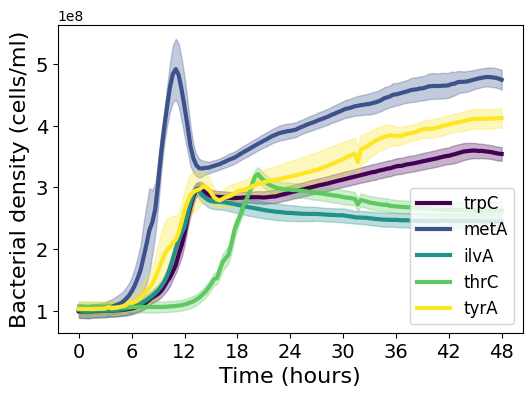

In [9]:

# Define X_values and template_string
X_values = [8]
template_string = 'M9_ZX_Y'

# Initialize lists to store all strains and all data
all_strains = []
all_data = []

# Loop over each strain label
for this_strain in strain_lbls:
    # Generate strain names using the template string and X_values
    for replacement_X in X_values:
        strain_string = template_string.replace('Y', this_strain).replace('Z', str(replacement_X))
        all_strains.append(strain_string)

# Load data for each strain and append it to all_data list
for strain_name in all_strains:
    print("** Strain: %s" % strain_name)
    tab_name_data = 'OD'
    data = load_data(sheet_url, tab_name_data, strain_name)
    all_data.append(data)


# Generate colors using a colorblind-friendly colormap
cmap_strains = plt.get_cmap('viridis')
strain_colors = [cmap_strains(i) for i in np.linspace(0, 1, len(strain_lbls))]

# Plot all data together with colors
plot_od_data(all_data, all_strains, strain_colors)


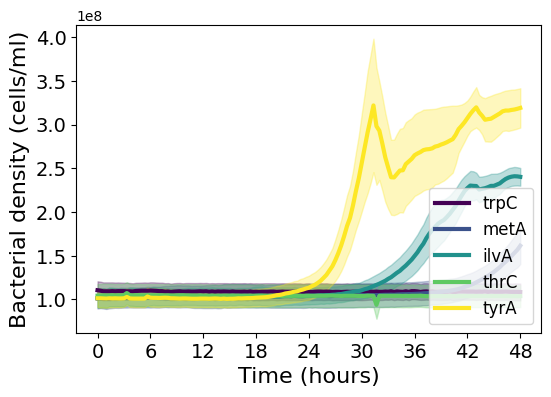

In [10]:

# Define X_values and template_string
X_values = [0]
template_string = 'M9_ZX_Y'

# Initialize lists to store all strains and all data
all_strains = []
all_data = []

# Loop over each strain label
for this_strain in strain_lbls:
    # Generate strain names using the template string and X_values
    for replacement_X in X_values:
        strain_string = template_string.replace('Y', this_strain).replace('Z', str(replacement_X))
        all_strains.append(strain_string)

# Load data for each strain and append it to all_data list
for strain_name in all_strains:
    #print("** Strain: %s" % strain_name)
    tab_name_data = 'OD'
    data = load_data(sheet_url, tab_name_data, strain_name)
    all_data.append(data)


# Plot all data together with colors
plot_od_data(all_data, all_strains, strain_colors)


## Dose-response experiments

In [11]:
from matplotlib.colors import LinearSegmentedColormap

def generate_custom_colormap(zero_color=(0.9, 0.9, 0.9), base_color=(0., 0., 0.)):
    """
    Generate a custom colormap that varies from a given base color to gray.

    Parameters:
    - base_color: Tuple representing the RGB values of the base color.

    Returns:
    - cmap: Custom colormap object.
    """
    # Define the colors for the custom colormap
    colors = [zero_color, base_color]  # Base color and gray

    # Define the color map boundaries
    boundaries = [0, 1]

    # Generate the custom colormap
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    return cmap


** Strain: M9_0X_trpC
** Strain: M9_1X_trpC
** Strain: M9_2X_trpC
** Strain: M9_3X_trpC
** Strain: M9_4X_trpC
** Strain: M9_8X_trpC


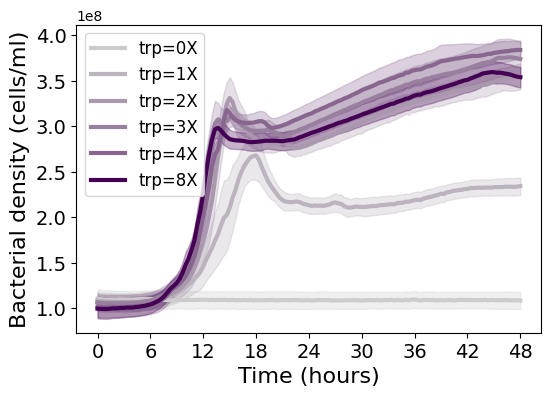

** Strain: M9_0X_metA
** Strain: M9_1X_metA
** Strain: M9_2X_metA
** Strain: M9_3X_metA
** Strain: M9_4X_metA
** Strain: M9_8X_metA


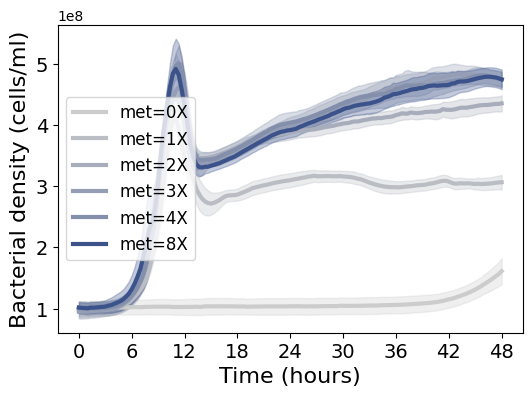

** Strain: M9_0X_ilvA
** Strain: M9_1X_ilvA
** Strain: M9_2X_ilvA
** Strain: M9_3X_ilvA
** Strain: M9_4X_ilvA
** Strain: M9_8X_ilvA


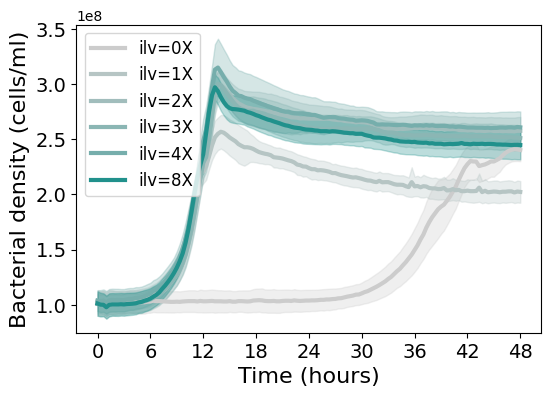

** Strain: M9_0X_thrC
** Strain: M9_1X_thrC
** Strain: M9_2X_thrC
** Strain: M9_3X_thrC
** Strain: M9_4X_thrC
** Strain: M9_8X_thrC


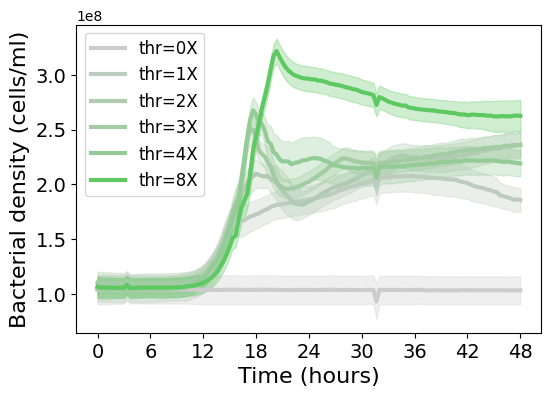

** Strain: M9_0X_tyrA
** Strain: M9_1X_tyrA
** Strain: M9_2X_tyrA
** Strain: M9_3X_tyrA
** Strain: M9_4X_tyrA
** Strain: M9_8X_tyrA


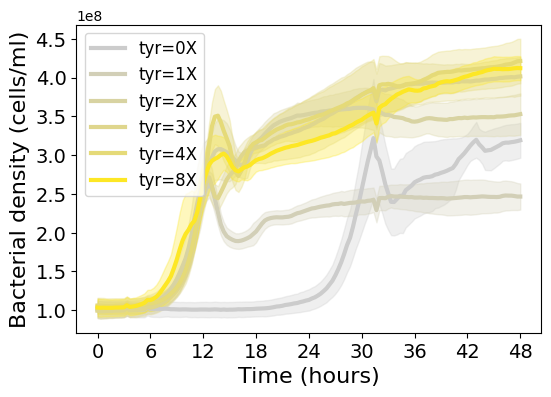

In [12]:

# Define the original string and X_values
template_string = 'M9_ZX_Y'
X_values = [0, 1, 2, 3, 4, 8]

# Loop over each strain label
for i, this_strain in enumerate(strain_lbls):
    # Initialize lists to store all strains and all data
    all_strains = []
    all_data = []

    # Generate strain names using the template string and X_values
    for replacement_X in X_values:
        # Replace 'Y' with the desired string and 'X' with the current value
        strain_string = template_string.replace('Y', this_strain).replace('Z', str(replacement_X))
        all_strains.append(strain_string)

    # Load data for each strain and append it to all_data list
    for strain_name in all_strains:
        print("** Strain: %s" % strain_name)
        tab_name_data = 'OD'
        data = load_data(sheet_url, tab_name_data, strain_name)
        all_data.append(data)

    # Get the colormap
    cmap_aa = generate_custom_colormap((0.8, 0.8, 0.8), strain_colors[i])

    # Plot each strain separately with a gradient of blues
    plt.figure(figsize=(6, 4))  # Adjust figure size if needed
    for i, (data, strain) in enumerate(zip(all_data, all_strains)):
        # Extract data
        time = data['Time']
        mean_od = data[strain + ' MeanOD']
        std_od = data[strain + ' StdOD']

        # Calculate the standard error of the mean (SEM)
        sample_size = 3  # Adjust this if you have a different number of replicates
        sem = std_od / np.sqrt(sample_size)

        # Calculate the color based on the dose
        dose=int(strain[3])
        color = cmap_aa(dose / 8)
        #color = cmap_strains(i / len(all_strains))

        # Plot the data for the current strain
        sem = pd.to_numeric(sem)
        mean_od = pd.to_numeric(mean_od)

        plt.fill_between(time, mean_od - sem, mean_od + sem, color=color, alpha=0.3)

        # Plot the mean line with adjusted line properties
        plt.plot(time, mean_od, linestyle='-', linewidth=3, color=color, label="%s=%sX"%(strain[-4:-1], dose))

    plt.xlabel('Time (hours)', fontsize=16)
    plt.ylabel('Bacterial density (cells/ml)', fontsize=16)
    plt.legend(fontsize=12)
    plt.xticks(np.arange(0, time.iloc[-1]+1, 6))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(False)
    plt.show()

## Experimental Dose-Response

In [13]:


# Define the original string and X_values
template_string = 'M9_ZX_Y'
X_values = [0, 1, 2, 3, 4, 8]

# Initialize lists to store all strains and all data
all_strains = []
all_data = []
all_aa = []

# Loop over each strain label
for this_strain in strain_lbls:
    # Generate strain names using the template string and X_values
    for replacement_X in X_values:
        # Replace 'Y' with the desired string and 'X' with the current value
        strain_string = template_string.replace('Y', this_strain).replace('Z', str(replacement_X))
        all_strains.append(strain_string)

        # Load data for each strain and append it to all_data list
        print("** Strain: %s" % strain_string)
        # Adjust the tab name to match your data
        tab_name_data = 'OD'
        data = load_data(sheet_url, tab_name_data, strain_string)
        all_data.append(data)
        all_aa.append(replacement_X)


** Strain: M9_0X_trpC
** Strain: M9_1X_trpC
** Strain: M9_2X_trpC
** Strain: M9_3X_trpC
** Strain: M9_4X_trpC
** Strain: M9_8X_trpC
** Strain: M9_0X_metA
** Strain: M9_1X_metA
** Strain: M9_2X_metA
** Strain: M9_3X_metA
** Strain: M9_4X_metA
** Strain: M9_8X_metA
** Strain: M9_0X_ilvA
** Strain: M9_1X_ilvA
** Strain: M9_2X_ilvA
** Strain: M9_3X_ilvA
** Strain: M9_4X_ilvA
** Strain: M9_8X_ilvA
** Strain: M9_0X_thrC
** Strain: M9_1X_thrC
** Strain: M9_2X_thrC
** Strain: M9_3X_thrC
** Strain: M9_4X_thrC
** Strain: M9_8X_thrC
** Strain: M9_0X_tyrA
** Strain: M9_1X_tyrA
** Strain: M9_2X_tyrA
** Strain: M9_3X_tyrA
** Strain: M9_4X_tyrA
** Strain: M9_8X_tyrA


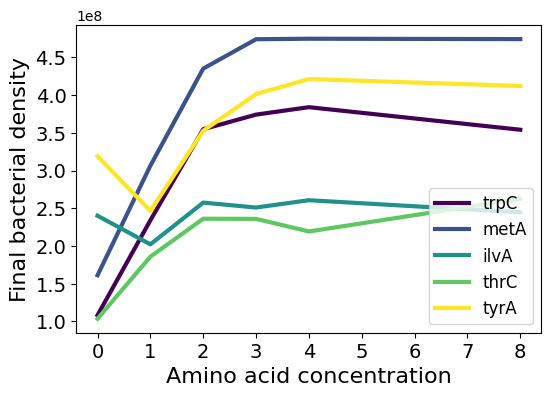

In [14]:

# Get the Blues colormap
cmap_strains = plt.get_cmap('Blues')
# Initialize lists to store concentration and density values
concentrations = []
densities = []


plt.figure(figsize=(6, 4))

# Loop over each strain
prev_strain=all_strains[0]

for i, (data, strain, aa) in enumerate(zip(all_data, all_strains, all_aa)):
    # Extract endpoint data
    density_at_endpoint = data['%s MeanOD' % strain].iloc[-1]
    amino_acid_concentration = aa

    if (prev_strain[-4:] != strain[-4:]):
      # Plot amino acid concentration vs. density as a line
      istrain = strain_lbls.index(prev_strain[-4:])

      plt.plot(concentrations, densities, linestyle='-', lw=3, label=prev_strain[-4:], color=strain_colors[istrain])

      concentrations=[]
      densities=[]


    # Append the concentration and density values to the lists

    concentrations.append(amino_acid_concentration)
    densities.append(density_at_endpoint)

    prev_strain=strain

# Plot the last line
plt.plot(concentrations, densities, linestyle='-', lw=3, label=strain[-4:], color=strain_colors[-1])


plt.xlabel('Amino acid concentration', fontsize=16)
plt.ylabel('Final bacterial density', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
plt.show()



## Model parametrization

In [15]:

def model_fit( t, rho, muK, strain):

    initial_R = 1.0  # Assume some initial resource concentration
    initial_B = data[strain + ' MeanOD'].iloc[0]  # Use the first measurement as initial bacterial density
    y0 = [initial_R, initial_B]
    _, B = simulate_model(rho, muK, y0, t)
    return B

def print_fit_results(popt, pcov):
    # Parameters are rho and muK
    rho, muK = popt
    print(f"Optimized Parameters:")
    print(f"rho (resource conversion rate): {rho:.4e}")  # Exponential notation for readability
    print(f"muK (mu/K parameter): {muK:.4e}")

    # Optionally, you could also print the standard deviations of the parameters
    # which are the square roots of the diagonal elements of the covariance matrix
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of the parameters
    print(f"Std of rho: {perr[0]:.4e}")
    print(f"Std of muK: {perr[1]:.4e}")



In [16]:

# Define X_values and template_string
X_values = [8]
template_string = 'M9_ZX_Y'
filtered_strains = []
# Loop over each strain label
for this_strain in strain_lbls:
    # Generate strain names using the template string and X_values
    for replacement_X in X_values:
        strain_string = template_string.replace('Y', this_strain).replace('Z', str(replacement_X))
        filtered_strains.append(strain_string)
print(filtered_strains)

['M9_8X_trpC', 'M9_8X_metA', 'M9_8X_ilvA', 'M9_8X_thrC', 'M9_8X_tyrA']




** Strain: M9_8X_trpC
Optimized Parameters:
rho (resource conversion rate): 2.4194e+08
muK (mu/K parameter): 5.7899e-10
Std of rho: 3.8103e+06
Std of muK: 2.2103e-11


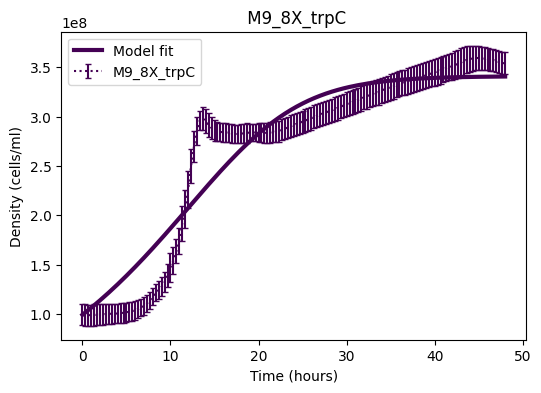



** Strain: M9_8X_metA
Optimized Parameters:
rho (resource conversion rate): 3.3017e+08
muK (mu/K parameter): 7.7379e-10
Std of rho: 5.6059e+06
Std of muK: 4.0435e-11


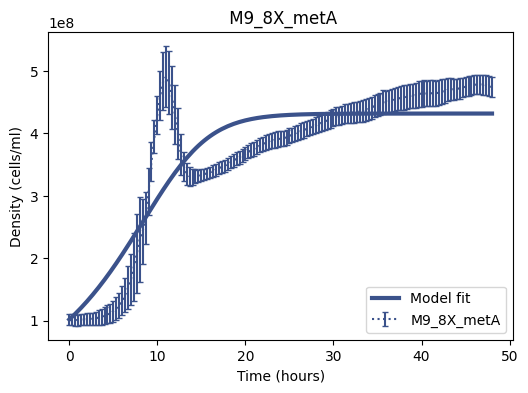



** Strain: M9_8X_ilvA
Optimized Parameters:
rho (resource conversion rate): 1.5596e+08
muK (mu/K parameter): 1.0578e-09
Std of rho: 3.0729e+06
Std of muK: 6.8610e-11


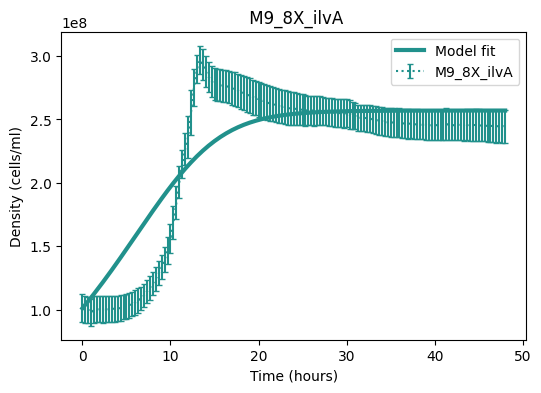



** Strain: M9_8X_thrC
Optimized Parameters:
rho (resource conversion rate): 1.7666e+08
muK (mu/K parameter): 5.7279e-10
Std of rho: 6.4629e+06
Std of muK: 4.8990e-11


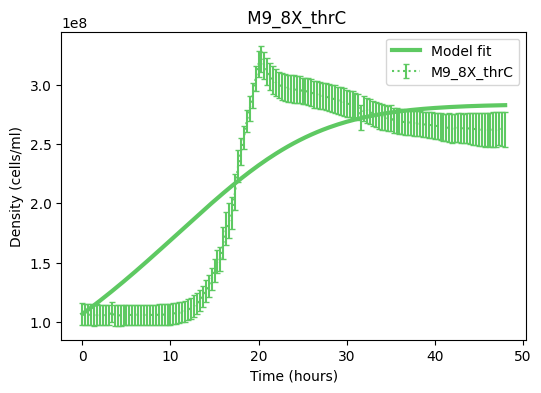



** Strain: M9_8X_tyrA
Optimized Parameters:
rho (resource conversion rate): 2.8996e+08
muK (mu/K parameter): 4.6761e-10
Std of rho: 3.9130e+06
Std of muK: 1.4095e-11


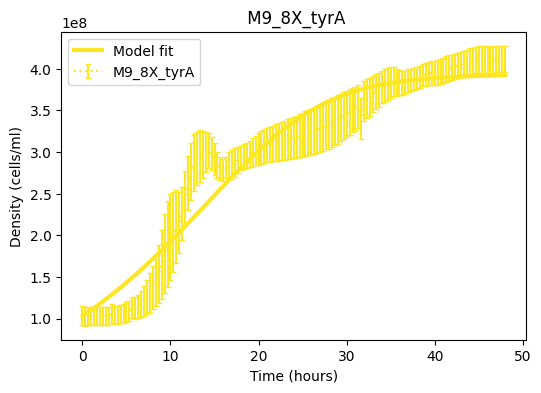

[{'parameters': [np.float64(5.78991149415923e-10), 1, np.float64(241938868.21282434), 2e-10, 100000000000.0], 'name': 'M9_8X_trpC'}, {'parameters': [np.float64(7.737873757479715e-10), 1, np.float64(330170515.8927891), 2e-10, 100000000000.0], 'name': 'M9_8X_metA'}, {'parameters': [np.float64(1.0578118334675554e-09), 1, np.float64(155961423.13713363), 2e-10, 100000000000.0], 'name': 'M9_8X_ilvA'}, {'parameters': [np.float64(5.727912166132926e-10), 1, np.float64(176656878.96936312), 2e-10, 100000000000.0], 'name': 'M9_8X_thrC'}, {'parameters': [np.float64(4.676079342129418e-10), 1, np.float64(289962560.3797477), 2e-10, 100000000000.0], 'name': 'M9_8X_tyrA'}]


In [17]:
beta_default=betax
Ki_default=Kix


cmap_strains = plt.get_cmap('viridis')
colors = [cmap_strains(i) for i in np.linspace(0, 1, len(all_strains))]

# Initialize a list to store parameters for each strain
strains_parameters = []

for strain_name in filtered_strains:
    print("\n\n** Strain: %s" % strain_name)
    tab_name_data = 'OD'
    data = load_data(sheet_url, tab_name_data, strain_name)

    if data is not None:
        time = data['Time'].values
        mean_od = data[strain_name + ' MeanOD'].values

        try:
            # Fit the curve and extract parameters rho and muK
            popt, pcov = curve_fit(lambda t, rho, muK: model_fit(t, rho, muK, strain_name), time, mean_od, p0=[1e9, 1e-11])
            rho, muK = popt

            # Print fit results
            print_fit_results(popt, pcov)

            # Append parameters to the list of strains_parameters
            strains_parameters.append({
                'parameters': [muK, 1, rho, beta_default, Ki_default],
                'name': strain_name

            })

            # Plot the OD simulation
            plot_od_sim(data, strain_name, popt)

        except Exception as e:
            plot_od_data([data], [strain_name], colors)
            print(f"An error occurred while fitting the curve for strain {strain_name}: {e}")

print(strains_parameters)
num_strains=len(strains_parameters)


## Population dynamics model

In [18]:
def model_population(t, u, parameters):
    num_strains = len(parameters)

    # Initialize the change in concentrations for each component
    dSdt = 0
    dAdt = [0] * num_strains  # Change in concentrations of amino acids
    dBdt = [0] * num_strains  # Change in bacterial densities

    # Loop through each strain's parameters
    for i in range(num_strains):
        # Extract parameters for the current strain
        Vm, Km, c, beta, Ki = parameters[i]
        Bi = max(0, u[1 + num_strains + i])
        A = max(0, u[i + 1])
        S = max(0, u[0])


        # Calculate uptake rate for the current strain
        U = Vm * S / (Km + S) * (A / (1 + A))


        # Calculate growth rate for the current strain
        G = c * U

        # Update the change in concentrations for each component
        dSdt -= U * S * Bi

        for j in range(num_strains):
          Bj=u[1 + num_strains + i]
          if i == j:
            dAdt[i] -= U * A * Bi  # Consumption of amino acid by auxotroph strain
          else:
            Aj=u[j + 1]
            Vmj, Kmj, cj, betaj, Kij = parameters[j]
            Uj = Vmj * S / (Kmj + S) * (Aj / (1 + Aj))
            Gj = cj * Uj

            dAdt[i] += betaj * Gj * Bj  # Production of amino acid by all other strains

        dBdt[i] = G * Bi  # Growth rate multiplied by bacterial density


    return [dSdt] + dAdt + dBdt

def simulate_multistrain(T, u0, p):

    # Define the time span
    t_span = (0, T)

    # Solve the ODE
    sol = solve_ivp(lambda t, y: model_population(t, y, p), t_span, u0, t_eval=np.linspace(0, T, 100))

    # Create a DataFrame to store the results
    df = pd.DataFrame(sol.y.transpose(), columns=['S'] + [f'A_{i+1}' for i in range(len(p))] + [f'X_{i+1}' for i in range(len(p))])

    # Add time column to DataFrame
    df['Time'] = sol.t

    return df


In [19]:
def plot_simulation(strains_parameters, results_df, T, environmental_conditions):
    """
    Plot the simulation results including environmental input, bacterial density,
    relative abundance, and Shannon diversity over time.
    """
    num_strains = len(strains_parameters)

    # --- Create subplots (now 4 rows)
    fig, axs = plt.subplots(4, figsize=(6, 12), sharex=True)

    # --- Plot 1: Environment Input ---
    lbls = []
    for i in range(num_strains):
        strain_name=strains_parameters[i]['name'][-4:]
        istrain = strain_lbls.index(strain_name[-4:])
        baseline_color = strain_colors[istrain]
        cmap_aa = generate_custom_colormap((1,1,1), baseline_color)
        #concentrations = results_df[f'A_{i+1}'].values

        time = results_df['Time'].values/T
        #for j, concentration in enumerate(environmental_conditions[i]):
        for j in range(len(environmental_conditions)):
            concentration=environmental_conditions[j][i]/Amax

            color = cmap_aa(concentration)
            axs[0].fill_between(time[j:j+2], i, i+1, color=color, alpha=0.7)
        lbls.append(strains_parameters[i]['name'][-4:])
    axs[0].set_yticks(np.arange(num_strains) + 0.5)
    axs[0].set_yticklabels(lbls)

    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].set_ylim([0, 10])
    axs[0].text(results_df['Time'].iloc[-1]/T / 2, num_strains + 0.5, 'Environment', ha='center', fontsize=14)

    # --- Plot 2: Bacterial Density (log-scale) ---
    for i in range(num_strains):
        strain_name = strains_parameters[i]['name'][-4:]
        istrain = strain_lbls.index(strain_name)
        color = strain_colors[istrain]
        axs[1].plot(results_df['Time'] / T, results_df[f'X_{i+1}'], color=color, linewidth=3)
    axs[1].set_yscale('log')
    axs[1].set_ylim([1e6, 5e9])
    axs[1].set_ylabel("Density (cells/mL)", fontsize=16)

    # --- Plot 3: Relative Abundance ---
    total_density = results_df[[f'X_{i+1}' for i in range(num_strains)]].sum(axis=1)
    for i in range(num_strains):
        strain_name = strains_parameters[i]['name'][-4:]
        istrain = strain_lbls.index(strain_name)
        color = strain_colors[istrain]
        axs[2].plot(results_df['Time'] / T, 100 * results_df[f'X_{i+1}'] / total_density, color=color, linewidth=3, label=strain_name)
    axs[2].set_ylabel("Relative abundance (%)", fontsize=16)

    # --- Plot 4: Diversity Index ---
    relative_proportions = calculate_relative_proportion(results_df)
    diversities = [shannon_diversity(row.values) for _, row in relative_proportions.iterrows()]
    axs[3].plot(results_df['Time'].values / T, diversities, color='k', lw=3)
    axs[3].set_ylabel("Diversity Index", fontsize=16)
    axs[3].set_ylim(0, 1.8)

    # --- Shared x-axis ---
    axs[3].set_xlabel("Time (seasons)", fontsize=16)
    axs[3].set_xlim([0, (results_df['Time']/T).iloc[-1]])

    # --- Styling ---
    for ax in axs:
        ax.tick_params(axis='both', labelsize=14)
    axs[1].legend(lbls, fontsize=12, loc="upper right")
    axs[2].legend(lbls, fontsize=12, loc="upper right")

    plt.tight_layout()
    plt.show()


In [20]:
def calculate_relative_proportion(results_df):
    # Extract columns for bacterial densities
    bacterial_density_columns = [col for col in results_df.columns if col.startswith('X_')]

    # Calculate total population
    total_population = results_df[bacterial_density_columns].sum(axis=1)

    # Calculate relative proportion of each bacterial strain to the total population
    relative_proportions = results_df[bacterial_density_columns].div(total_population, axis=0) * 100

    return relative_proportions

def shannon_diversity(freqs):
    total_freq = np.sum(freqs)
    if total_freq == 0:
        return 0  # Handle the case when there are no strains
    proportions = freqs / total_freq
    non_zero_proportions = proportions[proportions != 0]
    diversity = -np.sum(non_zero_proportions * np.log(non_zero_proportions))
    return diversity


In [21]:
def run_simulation(strains_parameters, u0, environmental_conditions, T):
    """
    Run the simulation for a given set of parameters and environmental conditions.

    Parameters:
    - strains_parameters: List of dictionaries containing parameters for each strain.
    - u0: initial conditions
    - environmental_conditions: List of environmental conditions for each cycle.
    - T: Total time.

    Returns:
    - results_df: DataFrame containing simulation results.
    - resultsT_df: DataFrame containing results at the end of each cycle.
    """
    # Initialize an empty list to store simulation results for each environmental condition
    results_list = []
    resultsT_list = []  # List to store results at the end of each cycle
    N = len(environmental_conditions)
    num_strains=len(strains_parameters)

    # Append initial conditions to resultsT_list
    initial_conditions = {'Time': 0, 'S': u0[0]}
    for i in range(num_strains):
        initial_conditions[f'A_{i+1}'] = u0[i+1]
        initial_conditions[f'X_{i+1}'] = B0
    resultsT_list.append(initial_conditions)

    # Loop through each environmental condition
    for iday, conditions in enumerate(environmental_conditions):


        u0[0]=S0
        # Update initial amino acid concentrations
        for i, aa_concentration in enumerate(conditions):
            u0[i+1] = aa_concentration

        # Append initial conditions for this cycle
        initial_conditions = {'Time': 0, 'S': u0[0]}
        for i in range(num_strains):
            initial_conditions[f'A_{i+1}'] = u0[i+1]
            initial_conditions[f'X_{i+1}'] = B0

        results_list .append(initial_conditions)

        #resultsT.append(initial_conditions)

        # Extract parameters for each strain
        parameters = [strain['parameters'] for strain in strains_parameters]

        # Solve the ODEs for this cycle
        simulation_results = simulate_multistrain(T, u0, parameters)
        simulation_results['Time'] = simulation_results['Time']+ iday*T
        results_list .extend(simulation_results.to_dict(orient='records'))

        # End of each day
        simulationT_results = {
            'Time': (iday + 1) * T,
            'S': simulation_results.iloc[-1]['S'],
            **{f'A_{i+1}': simulation_results.iloc[-1][f'A_{i+1}'] for i in range(num_strains)},
            **{f'X_{i+1}': simulation_results.iloc[-1][f'X_{i+1}'] for i in range(num_strains)}
        }

        resultsT_list.append(simulationT_results)


        # Update initial conditions for the next cycle
        u0 = [
            simulation_results.iloc[-1]['S'],
            *simulation_results.iloc[-1][[f'A_{i+1}' for i in range(num_strains)]],
            *[delta * simulation_results.iloc[-1][f'X_{i+1}'] for i in range(num_strains)]
        ]


    # Concatenate the results for all environmental conditions into a single DataFrame
    #results_df = pd.concat(results_list, axis=1)


    results_df = pd.DataFrame(results_list)
    resultsT_df = pd.DataFrame(resultsT_list)

    # Convert resultsT_list to DataFrame
    #resultsT_df = pd.DataFrame(resultsT_list)

    return results_df, resultsT_df




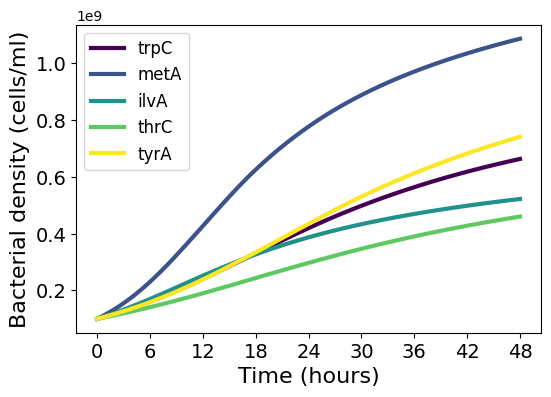

In [22]:


def run_GrowthCurves(list_parameters, Amax):

      num_strains = len(list_parameters)
      # Initialize lists to store results
      growthcurves_results_df_list = []
      growthcurves_resultsT_df_list = []

      # Set initial conditions
      u0 = [1.0, Amax, B0]

      for growthcurves_parameters in list_parameters:

        # Run simulation

        growthcurves_results_df, growthcurves_resultsT_df = run_simulation([growthcurves_parameters], u0, [[Amax]], T)

        # Append results to lists
        growthcurves_results_df_list.append(growthcurves_results_df)
        growthcurves_resultsT_df_list.append(growthcurves_resultsT_df)

      return growthcurves_results_df_list, growthcurves_results_df_list

def plot_GrowthCurves(strains_parameters, growthcurves_results_df_list):
    # Get the number of strains
    num_strains = len(strains_parameters)

    # Define a colormap
    cmap = plt.get_cmap('viridis')

    # Plot growth curves for each strain
    plt.figure(figsize=(6, 4))  # Adjust figure size if needed
    for i, growthcurves_results_df in enumerate(growthcurves_results_df_list):

        growthcurves_results_df.dropna(inplace=True)
        strain=strains_parameters[i]['name'][-4:]

        # Extract time and bacterial density values for the current strain
        time_values = growthcurves_results_df['Time']
        bacterial_density_values = growthcurves_results_df[f'X_1']

        # Get a color from the colormap for the current strain

        istrain = strain_lbls.index(strain[-4:])
        color = strain_colors[istrain]


        # Plot the growth curve for the current strain
        plt.plot(time_values, bacterial_density_values, '-', color=color, label=strain, linewidth=3)

    plt.xlabel('Time (hours)', fontsize=16)
    plt.ylabel('Bacterial density (cells/ml)', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks([0, 6, 12, 18, 24, 30, 36, 42, 48])
    plt.show()

N=1
num_strains=1
T=48
growthcurves_Amax=8.0
growthcurves_results_df_list, growthcurves_resultsT_df_list=run_GrowthCurves(strains_parameters, growthcurves_Amax)

plot_GrowthCurves(strains_parameters, growthcurves_results_df_list)

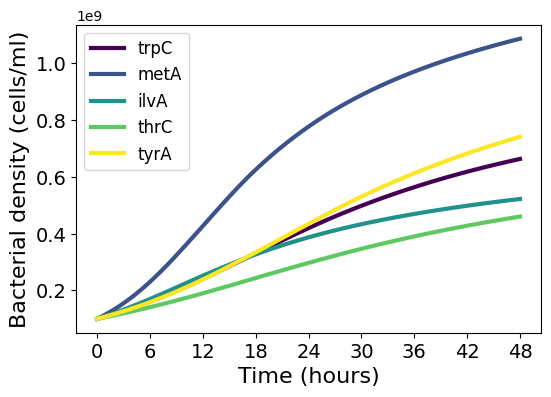

In [23]:

N=1
num_strains=1
T=48
growthcurves_Amax=8.0
growthcurves_results_df_list, growthcurves_resultsT_df_list=run_GrowthCurves(strains_parameters, growthcurves_Amax)

plot_GrowthCurves(strains_parameters, growthcurves_results_df_list)

In [24]:


def run_DoseResponse(doseresponse_parameters, Amax_values):
  num_strains = len(doseresponse_parameters)
  # Initialize lists to store results
  doseresponse_results_df_list = []
  doseresponse_resultsT_df_list = []

  # Loop over each Amax value
  for Amax in Amax_values:
      # Set initial conditions
      u0 = [S0] + [Amax] * num_strains + [B0] * num_strains

      # Set environmental conditions for each cycle
      aa_initial_values = Amax * np.ones(num_strains)
      environmental_conditions = [aa_initial_values for _ in range(N)]

      # Run simulation
      doseresponse_results_df, doseresponse_resultsT_df = run_simulation(doseresponse_parameters, u0, environmental_conditions, T)


      # Append results to lists
      doseresponse_results_df_list.append(doseresponse_results_df)
      doseresponse_resultsT_df_list.append(doseresponse_resultsT_df)


      #plot_simulation(doseresponse_parameters, doseresponse_results_df, N)
      #plot_simulation(doseresponse_parameters, doseresponse_resultsT_df, N)

  return doseresponse_results_df_list, doseresponse_resultsT_df_list


In [25]:

N = 1  # Number of days
T = 48  # Time interval

# Define range of Amax values
Amax_values = np.linspace(0, 8, 100)

# Initialize lists to store results
doseresponse_results_df_list = []
doseresponse_resultsT_df_list = []

# Iterate over each strain parameters
for doseresponse_parameters in strains_parameters:
    # Run DoseResponse experiment for each strain
    results_df_list, resultsT_df_list = run_DoseResponse([doseresponse_parameters], Amax_values)
    doseresponse_results_df_list.append(pd.concat(results_df_list))  # Combine DataFrames into a single DataFrame
    # Concatenate DataFrames in resultsT_df_list
    concatenated_df = pd.concat(resultsT_df_list)
    doseresponse_resultsT_df_list.append(concatenated_df)


print(len(doseresponse_resultsT_df_list))

5


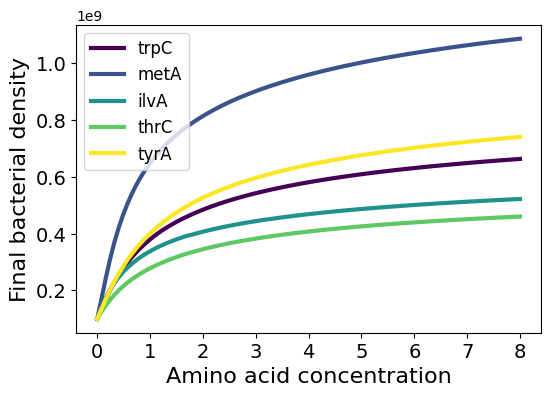

In [26]:
def plot_DoseResponse(Amax_values, doseresponse_parameters_list, doseresponse_resultsT_df_list):
    # Get the number of experiments
    num_experiments = len(doseresponse_resultsT_df_list)

    # Define a colormap
    cmap = plt.get_cmap('viridis')

    # Plot A_1 vs. X_1 for each experiment
    plt.figure(figsize=(6, 4))  # Adjust figure size if needed
    for i in range(num_experiments):
        # Extract A_1 and X_1 values for the current experiment
        experiment_df = doseresponse_resultsT_df_list[i]
        experiment_df = experiment_df[experiment_df['Time'] == T]
        A_1_values = Amax_values
        X_1_values = experiment_df['X_1']


        # Get the strain name for the current experiment
        strain_name = doseresponse_parameters_list[i]['name']
        istrain = strain_lbls.index(strain_name[-4:])
        color = strain_colors[istrain]

        # Plot the line connecting A_1 and X_1 values for the current experiment
        plt.plot(A_1_values, X_1_values, '-', color=color, label=strain_name[-4:], linewidth=3)

    plt.xlabel('Amino acid concentration', fontsize=16)
    plt.ylabel('Final bacterial density', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()


# Plot DoseResponse for all experiments
plot_DoseResponse(Amax_values, strains_parameters, doseresponse_resultsT_df_list)


In [27]:

def plot_DoseResponseTime(Amax_values, doseresponse_parameters, doseresponse_results_df_list):

  num_strains=len(doseresponse_parameters)

  # Get the Blues colormap
  cmap = plt.get_cmap('Blues')

  # Plot time-series of X_1 for the first day across different Amax values
  plt.figure(figsize=(10, 6))  # Adjust figure size if needed

  for i, doseresponse_results_df in enumerate(doseresponse_results_df_list):
      # Extract Time and X_1 values for the first day
      time_values_first_day = doseresponse_results_df['Time']
      X_1_values_first_day = doseresponse_results_df['X_1']

      # Calculate the color based on the current index and the total number of Amax values
      #color = cmap(i / len(doseresponse_results_df_list))

      istrain = strain_lbls.index(strain[-4:])

      baseline_color = strain_colors[istrain]
      cmap_aa = generate_custom_colormap((.9, .9, .9), baseline_color)

      # Plot X_1 values for the first day against Time values with the calculated color
      plt.plot(time_values_first_day, X_1_values_first_day, color=cmap_aa(Amax_values[i]/np.max(Amax_values)), label=f'Amax={Amax_values[i]}')

  plt.xlabel('Time (hours)', fontsize=16)
  plt.ylabel('Bacterial density (cells/ml)', fontsize=16)
  plt.legend()
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.grid(False)
  plt.show()


0 (np.float64(0.8), np.float64(0.8), np.float64(0.8), np.float64(1.0))
1 (np.float64(0.7331142274509804), np.float64(0.7002194823529412), np.float64(0.7409461960784314), np.float64(1.0))
2 (np.float64(0.6662284549019608), np.float64(0.6004389647058824), np.float64(0.6818923921568628), np.float64(1.0))
3 (np.float64(0.5993426823529412), np.float64(0.5006584470588236), np.float64(0.6228385882352941), np.float64(1.0))
4 (np.float64(0.5324569098039216), np.float64(0.40087792941176476), np.float64(0.5637847843137256), np.float64(1.0))
8 (np.float64(0.267004), np.float64(0.004874), np.float64(0.329415), np.float64(1.0))


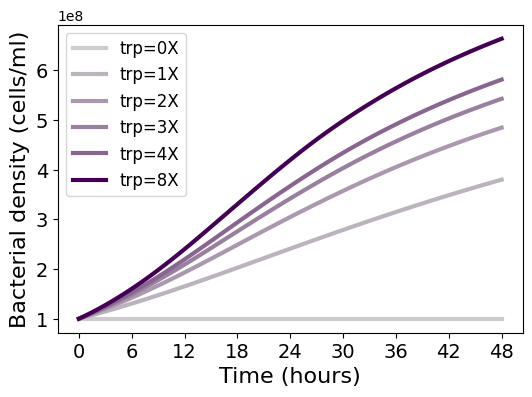

In [28]:

N = 1  # Number of days
T = 48  # Time interval
S0=2
B0=1e8

# Define range of Amax values
Amax_values = [0, 1, 2, 3,  4, 8]

dr_parameters=strains_parameters[0:1]

plt.figure(figsize=(6,4))  # Adjust figure size if needed

for Amax in Amax_values:
  # Set initial conditions
  u0 = [S0, Amax, B0]
  num_strains=1

  # Set environmental conditions for each cycle
  aa_initial_values = Amax * np.ones(num_strains)
  environmental_conditions = [aa_initial_values for _ in range(N)]


  strain_name = dr_parameters[0]['name']
  istrain = strain_lbls.index(strain_name[-4:])
  cmap_aa = generate_custom_colormap((0.8, 0.8, 0.8),strain_colors[istrain])
  color=cmap_aa(Amax/np.max(Amax_values))
  print(Amax, color)

  # Run simulation
  dr_results_df, dr_resultsT_df = run_simulation(dr_parameters, u0, environmental_conditions, T)

  plt.plot(dr_results_df['Time'],dr_results_df['X_1'], color=color, lw=3, label="%s=%sX"%(strain_name[-4:-1],Amax))

plt.xlabel('Time (hours)', fontsize=16)
plt.ylabel('Bacterial density (cells/ml)', fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(np.arange(0, T+1, 6))
plt.grid(False)
plt.show()



In [29]:
def filter_strains_by_name(strains_parameters, names):
    filtered_parameters = []
    for strain in strains_parameters:
        if strain['name'] in names:
            filtered_parameters.append(strain)
    return filtered_parameters


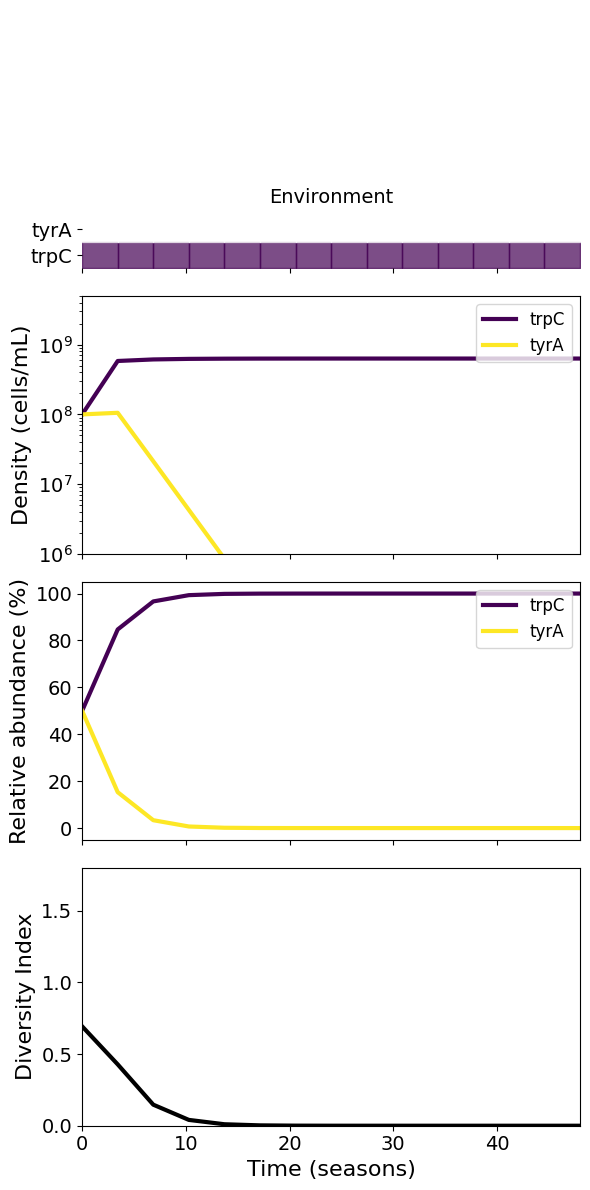

In [30]:
N = 14 #num_days
T = 48
Amax=4.0
Amin=0.0

S0=2.

names_to_filter = ['M9_8X_trpC', 'M9_8X_tyrA']
pair_parameters = filter_strains_by_name(strains_parameters, names_to_filter)
num_strains=len(pair_parameters)


u0 = [S0, Amax, Amin, B0, B0]

aa_initial_values=[Amax, Amin]
environmental_conditions = [(aa_initial_values) for _ in range(N)]

pair_results_df, pair_resultsT_df = run_simulation(pair_parameters, u0, environmental_conditions, T)
plot_simulation(pair_parameters, pair_resultsT_df, N, environmental_conditions)

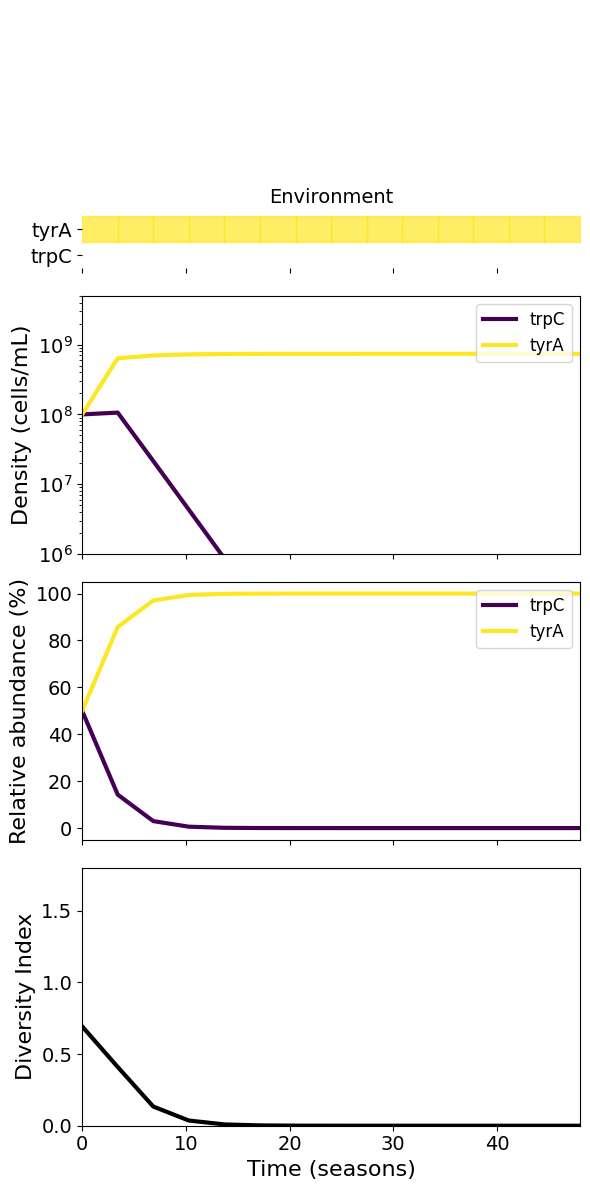

In [31]:

u0 = [S0, 0, 4, B0, B0]

aa_initial_values=[0, 4]
environmental_conditions = [(aa_initial_values) for _ in range(N)]  # Environmental conditions for each cycle

pair_results_df, pair_resultsT_df = run_simulation(pair_parameters, u0, environmental_conditions, T)
plot_simulation(pair_parameters, pair_resultsT_df, N, environmental_conditions)

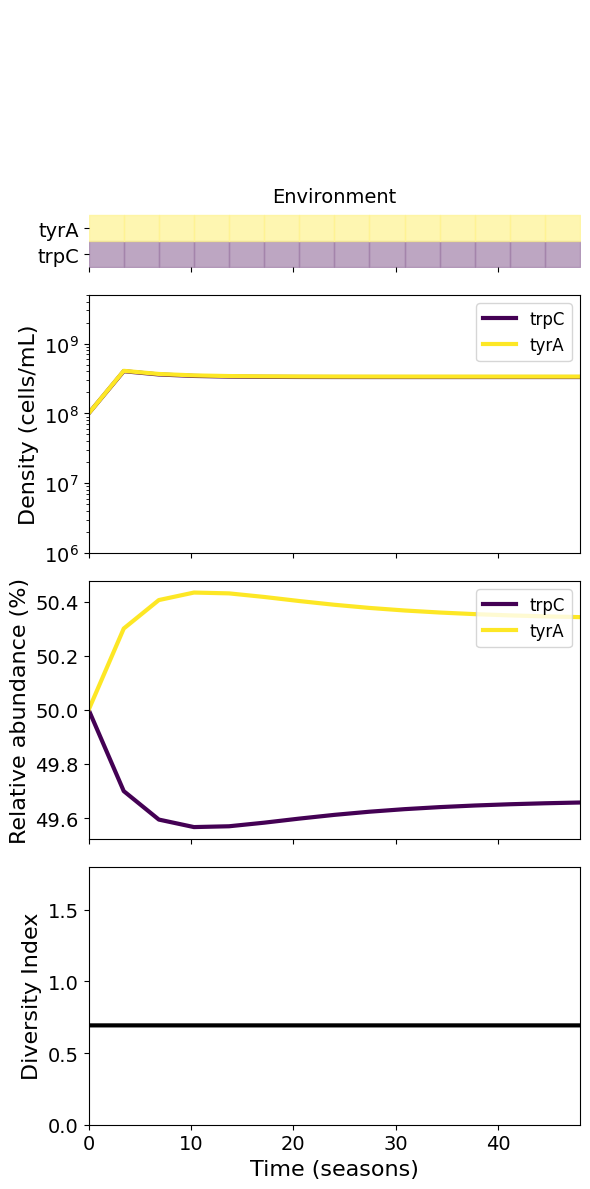

In [32]:

u0 = [S0, 2, 2, B0, B0]

aa_initial_values=[2,2]
environmental_conditions = [(aa_initial_values) for _ in range(N)]  # Environmental conditions for each cycle

pair_results_df, pair_resultsT_df = run_simulation(pair_parameters, u0, environmental_conditions, T)
plot_simulation(pair_parameters, pair_resultsT_df, N, environmental_conditions)

## Checkerboard

In [33]:

checkerboard_parameters = filter_strains_by_name(strains_parameters, names_to_filter)

num_strains=len(checkerboard_parameters)

N = 14 #num_days
T = 48
Amax=8.0
u0 = [S0] + [Amax] * num_strains + [B0] * num_strains

aa_initial_values=Amax*np.ones(num_strains)
environmental_conditions = [(aa_initial_values) for _ in range(N)]  # Environmental conditions for each cycle

naa=9

# Define a range of values for aa_x and aa_y
aa_x_values = np.linspace(0, Amax, naa)
aa_y_values = np.linspace(0, Amax, naa)

# Initialize arrays to store results
relative_proportion_heatmap_data = np.zeros((len(aa_x_values), len(aa_y_values)))
total_density_heatmap_data = np.zeros((len(aa_x_values), len(aa_y_values)))

# Run simulations for each combination of aa_x and aa_y
for i, aa_x in enumerate(aa_x_values):
    for j, aa_y in enumerate(aa_y_values):
        # Update environmental conditions for each simulation
        environmental_conditions = [[aa_x, aa_y] for _ in range(N)]  # Environmental conditions for each cycle

        # Run the simulation
        #results_df = run_simulation(strains_parameters, N, environmental_conditions, T)

        u0 = [S0] + [aa_x, aa_y] + [B0] * len(checkerboard_parameters)
        results_df, resultsT_df = run_simulation(checkerboard_parameters, u0, environmental_conditions, T)

        # Calculate relative proportion
        relative_proportion = calculate_relative_proportion(resultsT_df)

        # Store the endpoint relative proportion in the relative_proportion_heatmap_data array
        relative_proportion_heatmap_data[i, j] = relative_proportion.iloc[-1][0]

        # Calculate total density
        total_density = resultsT_df.iloc[-1].sum()  # Sum of Bx and By at the last time point

        # Store the total density in the total_density_heatmap_data array
        total_density_heatmap_data[i, j] = total_density


/tmp/ipython-input-2460342593.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  relative_proportion_heatmap_data[i, j] = relative_proportion.iloc[-1][0]
/tmp/ipython-input-2460342593.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  relative_proportion_heatmap_data[i, j] = relative_proportion.iloc[-1][0]
/tmp/ipython-input-2460342593.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  relative_proportion_heatmap_data[i, j] = 

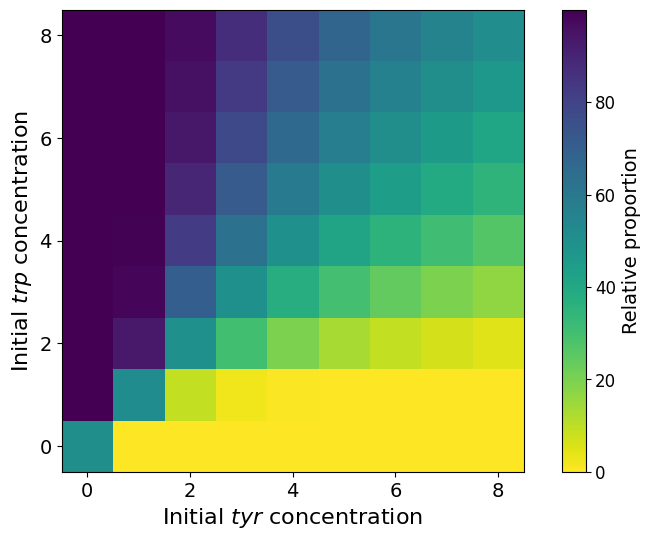

In [34]:
# Plot the heatmap with transparency based on total density
plt.figure(figsize=(10, 6))

# Get total density for each point
total_density = np.sum(relative_proportion_heatmap_data, axis=1)

# Create the heatmap
heatmap = plt.imshow(relative_proportion_heatmap_data, extent=[0, Amax+1, 0, Amax+1], origin='lower', cmap='viridis_r')

cbar = plt.colorbar(heatmap, label='Relative proportion')
cbar.ax.tick_params(labelsize=12)  # Adjust tick font size
cbar.set_label('Relative proportion', fontsize=14)  # Adjust label font size

plt.xlabel(r'Initial $\mathit{%s}$ concentration' % names_to_filter[1][-4:-1], fontsize=16)
plt.ylabel(r'Initial $\mathit{%s}$ concentration' % names_to_filter[0][-4:-1], fontsize=16)

plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks([0.5, 2.5, 4.5, 6.5, 8.5], labels=[0,2,4,6,8])
plt.yticks([0.5, 2.5, 4.5, 6.5, 8.5], labels=[0,2,4,6,8])
plt.show()


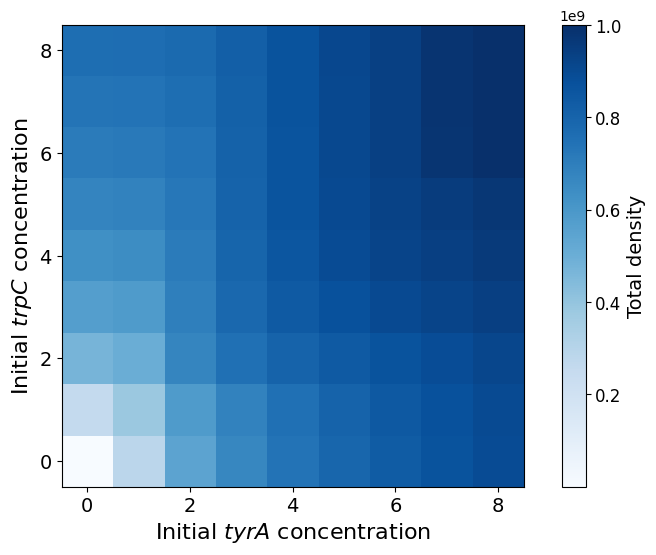

In [35]:
# Plot the heatmap of density
plt.figure(figsize=(10, 6))

# Create the heatmap for density
heatmap = plt.imshow(total_density_heatmap_data, extent=[0, Amax+1, 0, Amax+1], origin='lower', cmap='Blues')

plt.xlabel('Initial aa_x', fontsize=16)
plt.ylabel('Initial aa_y', fontsize=16)
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

cbar = plt.colorbar(heatmap, label='Total density')
cbar.ax.tick_params(labelsize=12)  # Adjust tick font size
cbar.set_label('Total density', fontsize=14)  # Adjust label font size

plt.xlabel(r'Initial $\mathit{%s}$ concentration' % names_to_filter[1][-4:], fontsize=16)
plt.ylabel(r'Initial $\mathit{%s}$ concentration' % names_to_filter[0][-4:], fontsize=16)
plt.xticks([0.5, 2.5, 4.5, 6.5, 8.5], labels=[0,2,4,6,8])
plt.yticks([0.5, 2.5, 4.5, 6.5, 8.5], labels=[0,2,4,6,8])
plt.show()


In [52]:
def simulate_feedback_pair(T, N, u0, strains, Amax, Amin, target_proportion=50):
    ncycles = N
    u0_pop = u0
    results = []
    resultsT = []
    tdone=[]
    for i in range(ncycles):
        # Append initial conditions for this cycle
        initial_conditions = {'Time': i * T, 'S': u0_pop[0]}
        for j in range(num_strains):
            initial_conditions[f'A_{j}'] = u0_pop[j+1]
            initial_conditions[f'B_{j}'] = u0_pop[num_strains+j+1]

        results.append(initial_conditions)
        #resultsT.append(initial_conditions)

        # Define the time interval for this cycle
        tspan_cycle = (0, T)  # Start and end times for the cycle

        # Solve the ODEs for this cycle
        p = [strain['parameters'] for strain in strains]

        day_df=simulate_multistrain(T, u0_pop, p)

        day_df['Time'] = day_df['Time']+ i*T


        relative_proportion = calculate_relative_proportion(day_df)
        final_freqs = [relative_proportion.iloc[-1][f'X_{i+1}'] for i in range(num_strains)]


        # Adjust amino acid concentrations for the next cycle based on the final proportion of the first strain
        if final_freqs[0] < target_proportion:
            next_aa_concentrations = [Amax, Amin]
        else:
            next_aa_concentrations = [Amin, Amax]

        #print(i, ': ' , final_freqs, ' -> ',next_aa_concentrations )


        # Update initial conditions for the next cycle
        u0_pop = [
            S0,
            *next_aa_concentrations,
            *[delta * day_df.iloc[-1][f'X_{i+1}'] for i in range(len(strains))]
        ]



        # Append the results for this cycle

        for t, row in zip(day_df['Time'], day_df.iterrows()):
            cycle_result = {'Time': t}
            for j in range(num_strains):
                cycle_result[f'S'] = row[1]['S']
                cycle_result[f'A_{j+1}'] = row[1][f'A_{j+1}']
                cycle_result[f'X_{j+1}'] = row[1][f'X_{j+1}']
            results.append(cycle_result)


        # End of each day
        for t, row in zip(day_df['Time'], day_df.iterrows()):

            if t%24==0:
              if t not in tdone:

                cycle_resultT = {'Time': t}
                cycle_resultT[f'S'] = row[1]['S']
                for j in range(num_strains):
                  cycle_resultT[f'A_{j+1}'] = row[1][f'A_{j+1}']
                  cycle_resultT[f'X_{j+1}'] = row[1][f'X_{j+1}']
                resultsT.append(cycle_resultT)
                tdone.append(t)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    resultsT_df = pd.DataFrame(resultsT)
    return results_df, resultsT_df



def simulate_feedback_multi(T, N, u0, strains, Amax, Amin):
    environmental_conditions=[]
    ncycles = N
    u0_pop = u0
    results = []
    resultsT = []
    tdone=[]
    for i in range(ncycles):
        # Append initial conditions for this cycle
        initial_conditions = {'Time': i * T, 'S': u0_pop[0]}
        for j in range(num_strains):
            initial_conditions[f'A_{j}'] = u0_pop[j+1]
            initial_conditions[f'B_{j}'] = u0_pop[num_strains+j+1]

        results.append(initial_conditions)
        #resultsT.append(initial_conditions)

        # Define the time interval for this cycle
        tspan_cycle = (0, T)  # Start and end times for the cycle

        # Solve the ODEs for this cycle
        p = [strain['parameters'] for strain in strains]

        day_df=simulate_multistrain(T, u0_pop, p)

        day_df['Time'] = day_df['Time']+ i*T


        relative_proportion = calculate_relative_proportion(day_df)
        final_freqs = [relative_proportion.iloc[-1][f'X_{i+1}'] for i in range(num_strains)]


        # Adjust amino acid concentrations for the next cycle based on the final proportion of the first strain
        #if final_freq < target_proportion:
        #    next_aa_concentrations = [1.0, 0.]
        #else:
        #    next_aa_concentrations = [0., 1.0]

        next_aa_concentrations = [0] * num_strains  # Initialize with zeros for all amino acids

        # Find the index of the strain with the highest density
        max_density_index = final_freqs.index(max(final_freqs))

        # Adjust amino acid concentrations based on the strain with the highest density
        next_aa_concentrations = [0] * num_strains  # Initialize with zeros for all amino acids
        for j in range(num_strains):
            if j != max_density_index:
                # For strains other than the one with the highest density, set their concentration to 1
                next_aa_concentrations[j] = Amax
            # For the strain with the highest density, set its concentration to 0
            # You can also perform some other adjustment here if needed
            else:
                next_aa_concentrations[j] = Amin

            environmental_conditions.append(next_aa_concentrations)
        #print(i, ': ' , final_freqs, ' -> ',next_aa_concentrations )


        # Update initial conditions for the next cycle
        u0_pop = [
            S0,
            *next_aa_concentrations,
            *[delta * day_df.iloc[-1][f'X_{i+1}'] for i in range(len(strains))]
        ]



        # Append the results for this cycle

        for t, row in zip(day_df['Time'], day_df.iterrows()):
            cycle_result = {'Time': t}
            for j in range(num_strains):
                cycle_result[f'S'] = row[1]['S']
                cycle_result[f'A_{j+1}'] = row[1][f'A_{j+1}']
                cycle_result[f'X_{j+1}'] = row[1][f'X_{j+1}']
            results.append(cycle_result)


        # End of each day
        for t, row in zip(day_df['Time'], day_df.iterrows()):

            if t%24==0:
              if t not in tdone:

                cycle_resultT = {'Time': t}
                cycle_resultT[f'S'] = row[1]['S']
                for j in range(num_strains):
                  cycle_resultT[f'A_{j+1}'] = row[1][f'A_{j+1}']
                  cycle_resultT[f'X_{j+1}'] = row[1][f'X_{j+1}']
                resultsT.append(cycle_resultT)
                tdone.append(t)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    resultsT_df = pd.DataFrame(resultsT)
    #print(environmental_conditions)
    return results_df, resultsT_df, environmental_conditions


## Figure 4. Stabilization



In [45]:
def plot_simulation_inset(strains_parameters, results_df, T, environmental_conditions):
    num_strains = len(strains_parameters)

    fig, ax = plt.subplots(1, figsize=(3, 1))

    total_density = results_df[[f'X_{i+1}' for i in range(num_strains)]].sum(axis=1)
    for i in range(num_strains):
        strain_name = strains_parameters[i]['name'][-4:]
        istrain = strain_lbls.index(strain_name)
        color = strain_colors[istrain]
        ax.plot(results_df['Time'] / T,
                100 * results_df[f'X_{i+1}'] / total_density,
                color=color, linewidth=3, label=strain_name)

    #ax.set_ylabel("Relative abundance (%)", fontsize=16)
    plt.tight_layout()
    plt.show()


#import itertools

# Get only the first pair
#pair_parameters = next(itertools.combinations(strains_parameters, 2))
#print(pair_parameters)

#plot_simulation_inset(pair_parameters, stabilization_resultsT_feedback_df, N, environmental_conditions)

['M9_8X_trpC', 'M9_8X_metA']


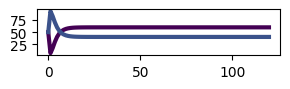

['M9_8X_trpC', 'M9_8X_ilvA']


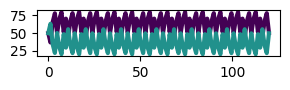

['M9_8X_trpC', 'M9_8X_thrC']


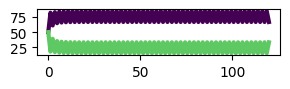

['M9_8X_trpC', 'M9_8X_tyrA']


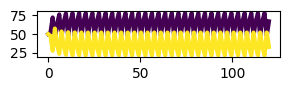

['M9_8X_metA', 'M9_8X_ilvA']


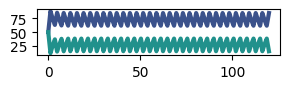

['M9_8X_metA', 'M9_8X_thrC']


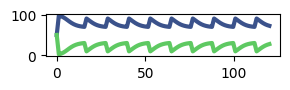

['M9_8X_metA', 'M9_8X_tyrA']


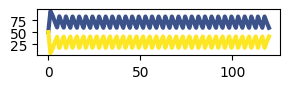

['M9_8X_ilvA', 'M9_8X_thrC']


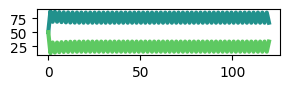

['M9_8X_ilvA', 'M9_8X_tyrA']


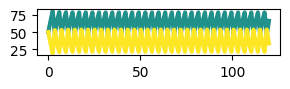

['M9_8X_thrC', 'M9_8X_tyrA']


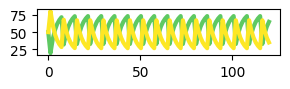

In [61]:

# Define initial amino acid concentrations
T=120
N = 100  # Number of days
#aa_initial_values=np.ones(num_strains)*A0

Amax=8
Amin=1
S0=2
B0=1e6

target=70 #30

# Initialize a dictionary to store the final proportions for each pair of strains
final_proportions = {}

# Store historical abundance distributions for each pair
distributions = {}


# Iterate through all possible pairs of strains from the names_to_filter list
for pair_parameters in itertools.combinations(strains_parameters, 2):
    # Extract the names of the two strains in the current pair
    strain_names = [strain['name'] for strain in pair_parameters]

    print(strain_names)
    num_strains=len(strain_names)

    # Define initial conditions
    u0 = [S0] + [Amax] * num_strains + [B0] * num_strains

    # Run the feedback simulation
    stabilization_results_feedback_df, stabilization_resultsT_feedback_df = simulate_feedback_pair(T, N, u0, pair_parameters, Amax, Amin, target)

    # Calculate the relative proportion
    stabilization_relative_proportion_feedback = calculate_relative_proportion(stabilization_results_feedback_df)

    # --- Store historical abundance data for histograms ---
    pair_key = tuple(strain_names)
    pair_label = f"{pair_key[0][-4:]} vs. {pair_key[1][-4:]}"
    time = stabilization_results_feedback_df['Time'].values
    dt = np.diff(time, prepend=time[0])  # time intervals

    distributions[pair_key] = {
        'pair_label': pair_label,
        'X_1': stabilization_relative_proportion_feedback['X_1'].values,
        'X_2': stabilization_relative_proportion_feedback['X_2'].values,
        'dt': dt
    }


    # Store time series for inset plotting
    #time_series_data[tuple(strain_names)] = {
    #    'time': stabilization_results_feedback_df['Time'].values,
    #    'X_1': stabilization_relative_proportion_feedback['X_1'].values,
    #    'X_2': stabilization_relative_proportion_feedback['X_2'].values
    #}

    # Compute time-weighted average proportions
    time = stabilization_results_feedback_df['Time'].values
    dt = np.diff(time, prepend=time[0])
    weighted_avg = (
        stabilization_relative_proportion_feedback.mul(dt, axis=0).sum() / dt.sum()
    )

    # Save the averages
    final_proportions[tuple(strain_names)] = weighted_avg

    # Get the final proportion at the endpoint of the simulation
    #stabilization_endpoint_relative_proportion_feedback = stabilization_relative_proportion_feedback.iloc[-1]

    # Store the final proportion for the current pair of strains
    #final_proportions[tuple(strain_names)] = stabilization_endpoint_relative_proportion_feedback



    plot_simulation_inset(pair_parameters, stabilization_resultsT_feedback_df, N, environmental_conditions)



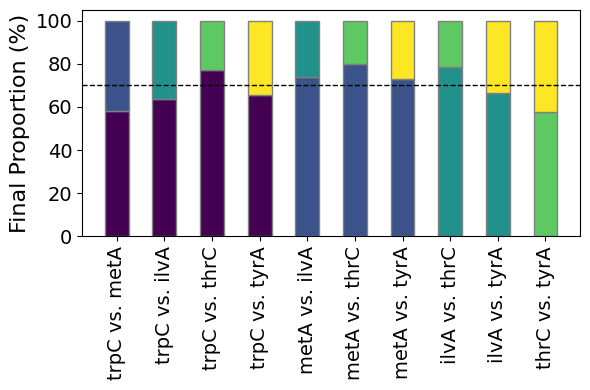

In [62]:


# Define the strain pairs and their final proportions
strain_pairs = list(final_proportions.keys())
final_proportions_values = list(final_proportions.values())

# Extract the proportions for each strain in each pair
proportions_1 = [proportions['X_1'] for proportions in final_proportions_values]
proportions_2 = [proportions['X_2'] for proportions in final_proportions_values]

# Define the width of the bars
bar_width = 0.5

# Set the positions for the bars
r = np.arange(len(strain_pairs))

# Create the stacked bar chart
plt.figure(figsize=(6, 4))

# Iterate over each strain pair
for idx, pair in enumerate(strain_pairs):
    # Extract the strain names
    strain_1_name = pair[0][-4:]
    strain_2_name = pair[1][-4:]

    # Find the index of each strain in the strains_parameters list
    strain_1_idx = next((i for i, d in enumerate(strains_parameters) if d['name'] == pair[0]), None)
    strain_2_idx = next((i for i, d in enumerate(strains_parameters) if d['name'] == pair[1]), None)

    # Retrieve the color for each strain
    strain_1_color = strain_colors[strain_1_idx]
    strain_2_color = strain_colors[strain_2_idx]

    # Plot the stacked bars for each strain pair
    plt.bar(r[idx] , proportions_1[idx], color=strain_1_color, width=bar_width, edgecolor='grey', label=f'Strain {strain_1_name}')
    plt.bar(r[idx] , proportions_2[idx], color=strain_2_color, width=bar_width, edgecolor='grey', bottom=proportions_1[idx], label=f'Strain {strain_2_name}')

# Add a dotted line at the target value
plt.axhline(y=target, linestyle='--', color='black', linewidth=1)

# Add labels and title
plt.ylabel('Final Proportion (%)', fontsize=16)
plt.xticks([r for r in range(len(strain_pairs))], [f"{pair[0][-4:]} vs. {pair[1][-4:]}" for pair in strain_pairs], rotation='vertical')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()


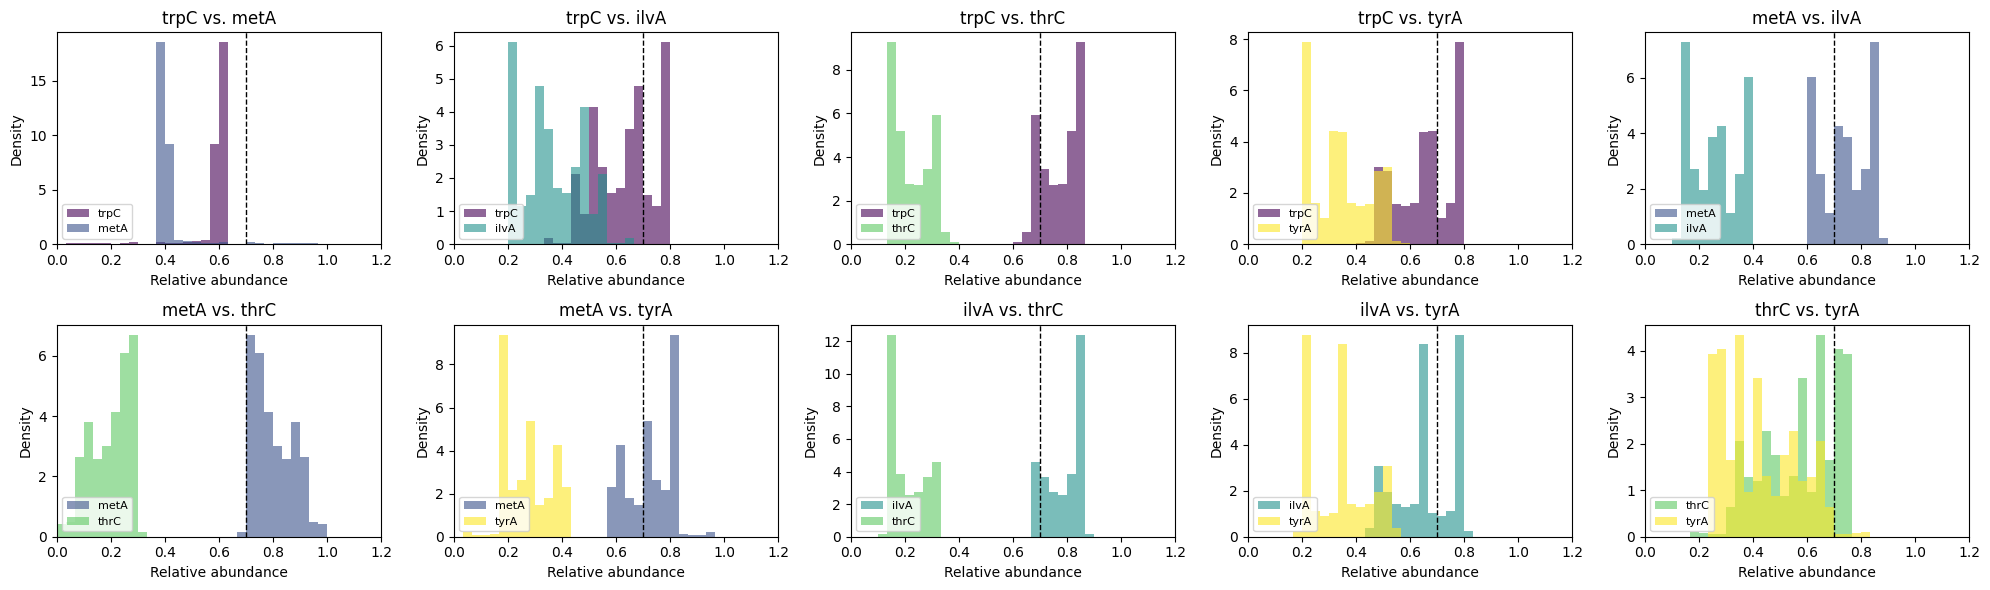

In [63]:
def color_for_strain(strain_name):
    return strain_colors[next(i for i, d in enumerate(strains_parameters) if d['name'] == strain_name)]

def _sanitize_series(vals, weights):
    vals = np.asarray(vals, dtype=float)
    weights = np.asarray(weights, dtype=float)

    # convert from % to fraction if needed
    if np.nanmax(vals) > 1.5:
        vals = vals / 100.0

    # mask bad values
    m = np.isfinite(vals) & np.isfinite(weights) & (weights >= 0)
    vals = vals[m]
    weights = weights[m]

    # clip to [0,1]
    vals = np.clip(vals, 0.0, 1.0)

    # normalize weights; if they sum to ~0, use uniform weights
    wsum = weights.sum()
    if wsum <= 0 or np.isnan(wsum):
        weights = np.ones_like(vals) / max(len(vals), 1)
    else:
        weights = weights / wsum

    return vals, weights

pairs = list(distributions.keys())
n = len(pairs)
if n == 0:
    print("No distributions found. Make sure you populated `distributions` inside the simulation loop.")
else:
    cols = min(5, n)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows), squeeze=False)
    axes = axes.ravel()

    bins = np.linspace(0, 1, 31)
    target_frac = (target / 100.0) if target > 1 else float(target)

    for i, pair in enumerate(pairs):
        ax = axes[i]
        entry = distributions[pair]

        x1, w1 = _sanitize_series(entry['X_1'], entry['dt'])
        x2, w2 = _sanitize_series(entry['X_2'], entry['dt'])

        c1 = color_for_strain(pair[0])
        c2 = color_for_strain(pair[1])

        # Use density=True with normalized weights (safe) or density=False; both are fine.
        ax.hist(x1, bins=bins, weights=w1, density=True, alpha=0.6, label=pair[0][-4:], color=c1)
        ax.hist(x2, bins=bins, weights=w2, density=True, alpha=0.6, label=pair[1][-4:], color=c2)

        ax.axvline(target_frac, linestyle='--', color='black', linewidth=1)
        ax.set_title(entry['pair_label'])
        ax.set_xlabel('Relative abundance')
        ax.set_ylabel('Density')
        ax.legend(fontsize=8, loc='lower left')
        ax.set_xlim(0, 1.2)

    # hide any unused subplots
    for j in range(i+1, rows*cols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

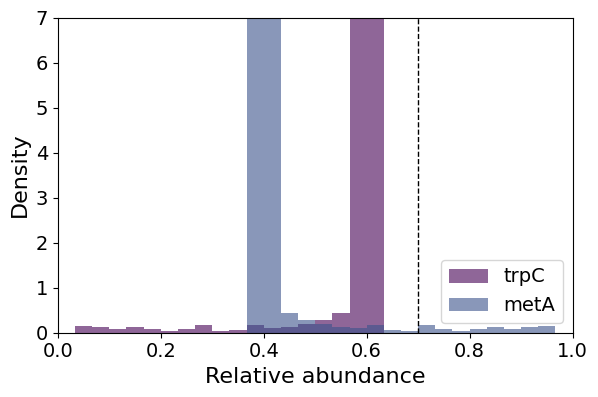

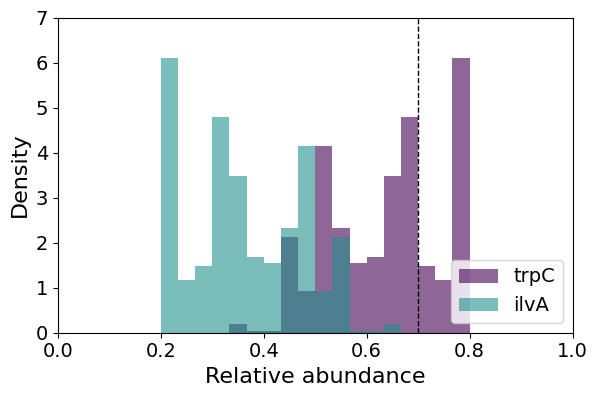

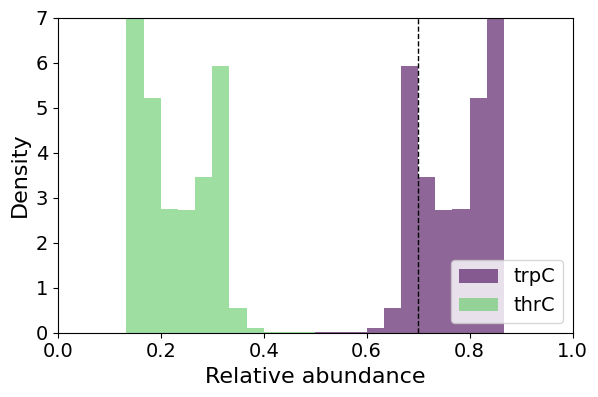

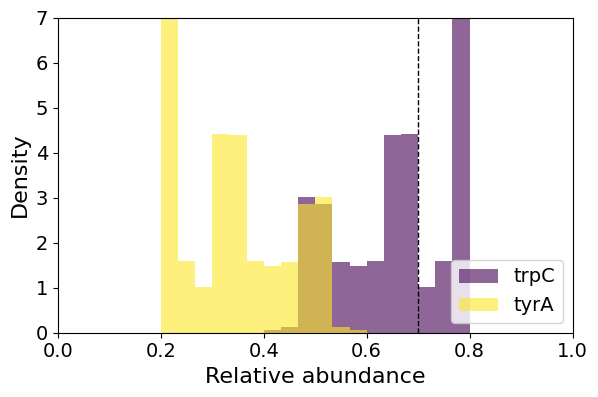

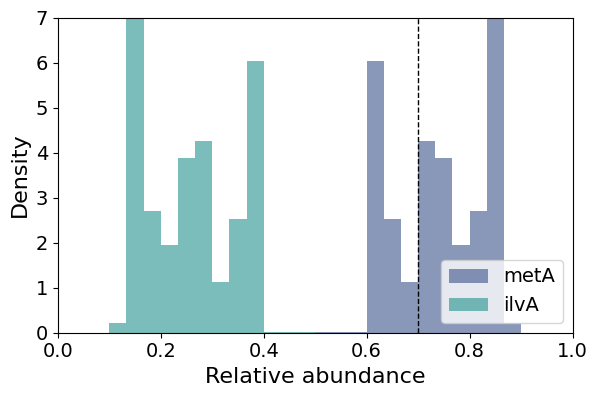

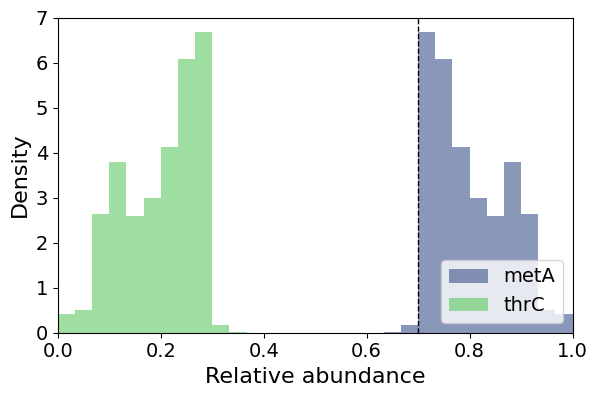

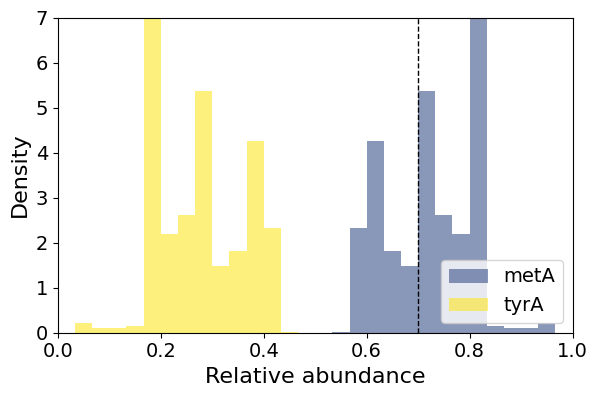

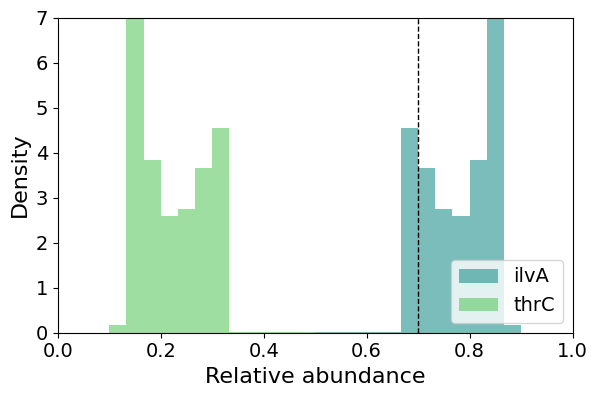

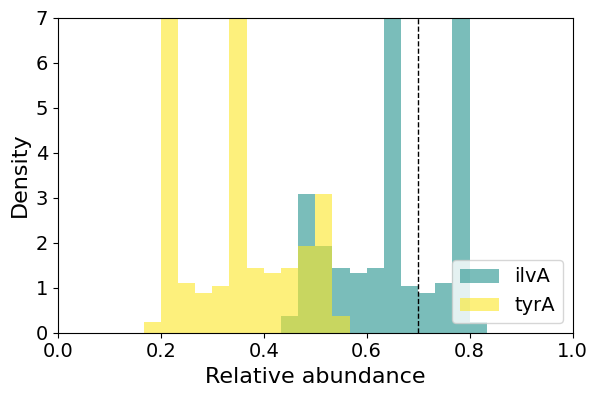

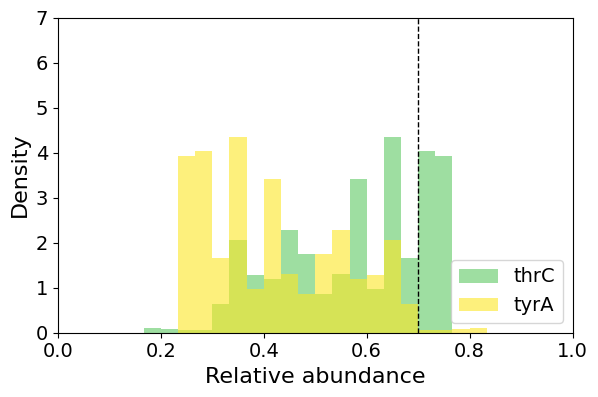

In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_distributions_separately(distributions, target, strains_parameters, strain_colors,
                                  bins=np.linspace(0, 1, 31), out_dir=None, dpi=150):
    """
    Make one histogram figure per pair from `distributions`.
    If out_dir is provided, figures are saved there; otherwise they are just shown.
    """
    def color_for_strain(strain_name):
        return strain_colors[next(i for i, d in enumerate(strains_parameters) if d['name'] == strain_name)]

    def _sanitize_series(vals, weights):
        vals = np.asarray(vals, dtype=float)
        weights = np.asarray(weights, dtype=float)
        if np.nanmax(vals) > 1.5:
            vals = vals / 100.0  # convert % -> fraction
        m = np.isfinite(vals) & np.isfinite(weights) & (weights >= 0)
        vals = np.clip(vals[m], 0.0, 1.0)
        weights = weights[m]
        wsum = weights.sum()
        weights = (np.ones_like(vals) / max(len(vals), 1)) if (wsum <= 0 or np.isnan(wsum)) else (weights / wsum)
        return vals, weights

    if out_dir:
        os.makedirs(out_dir, exist_ok=True)

    target_frac = (target / 100.0) if target > 1 else float(target)

    for pair, entry in distributions.items():
        x1, w1 = _sanitize_series(entry['X_1'], entry['dt'])
        x2, w2 = _sanitize_series(entry['X_2'], entry['dt'])

        c1 = color_for_strain(pair[0])
        c2 = color_for_strain(pair[1])

        plt.figure(figsize=(6, 4))
        plt.hist(x1, bins=bins, weights=w1, density=True, alpha=0.6, label=pair[0][-4:], color=c1)
        plt.hist(x2, bins=bins, weights=w2, density=True, alpha=0.6, label=pair[1][-4:], color=c2)

        plt.axvline(target_frac, linestyle='--', color='black', linewidth=1)
        #plt.title(entry['pair_label'])
        plt.xlabel('Relative abundance', fontsize=16)
        plt.ylabel('Density', fontsize=16)
        plt.xlim(0, 1.0)
        plt.ylim(0, 7.0)
        plt.legend(fontsize=14, loc='lower right')
        plt.tight_layout()


        plt.yticks(fontsize=14)
        plt.xticks(fontsize=14)

        if out_dir:
            fname = f"{entry['pair_label'].replace(' ', '_').replace(':','-')}.png"
            path = os.path.join(out_dir, fname)
            plt.savefig(path, dpi=dpi, bbox_inches='tight')
            plt.close()
        else:
            plt.show()


# e.g., just show each plot
plot_distributions_separately(distributions, target, strains_parameters, strain_colors)


## Figure 5. Multistrain

Final proportion: X_1    4.894928e+01
X_2    9.194865e+00
X_3    3.150645e+01
X_4    2.594125e-11
X_5    1.034940e+01
Name: 10099, dtype: float64


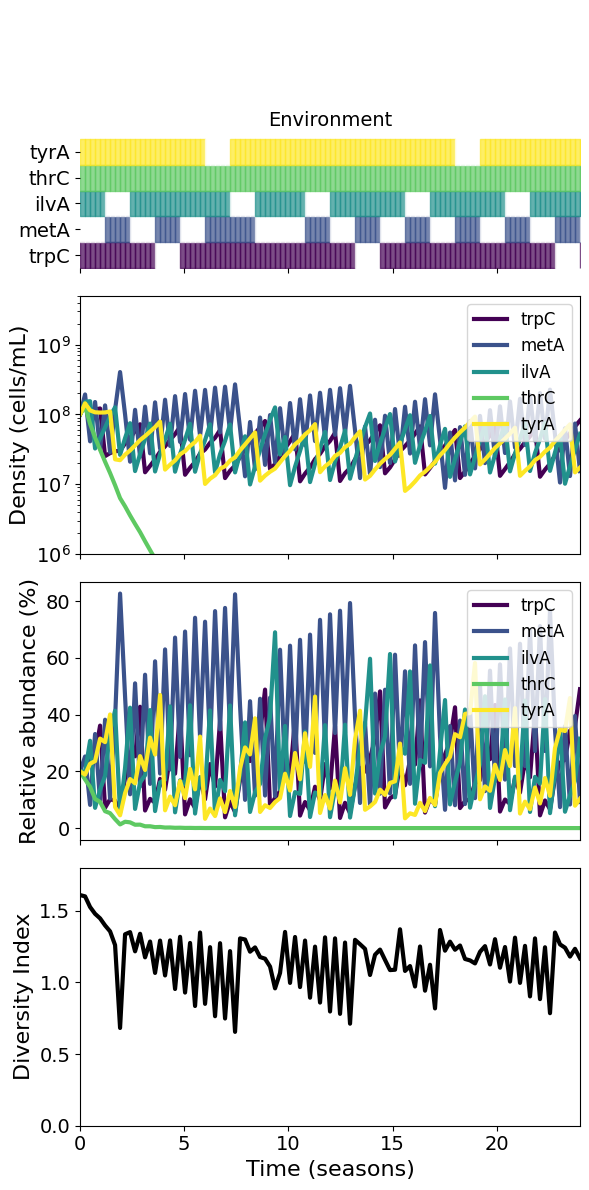

In [69]:


# Define initial amino acid concentrations
T=24
N = 100  # Number of days
#aa_initial_values=np.ones(num_strains)*A0
A0=0.25
Amax=8
Amin=0
S0=2
B0=1e8

# Define initial conditions
num_strains = len(strains_parameters)  # Number of strains
u0 = [S0] + [A0] * num_strains  + [B0] * num_strains


# Run the feedback simulation
results_feedback_df, resultsT_feedback_df, feedback_environment = simulate_feedback_multi(T, N, u0, strains_parameters, Amax, Amin)


# Calculate the relative proportion
relative_proportion_feedback = calculate_relative_proportion(results_feedback_df)
endpoint_relative_proportion_feedback = relative_proportion_feedback.iloc[-1]
print('Final proportion: %s' % endpoint_relative_proportion_feedback)


# Plot the simulation results
#plot_simulation(strains_parameters, results_feedback_df, N, environmental_conditions)
plot_simulation(strains_parameters, resultsT_feedback_df, N, feedback_environment)
#plot_diversity([resultsT_feedback_df])


Final proportion: X_1    1.064477e-14
X_2    1.000000e+02
X_3    2.889712e-11
X_4    4.342018e-20
X_5    2.557405e-15
Name: 10099, dtype: float64


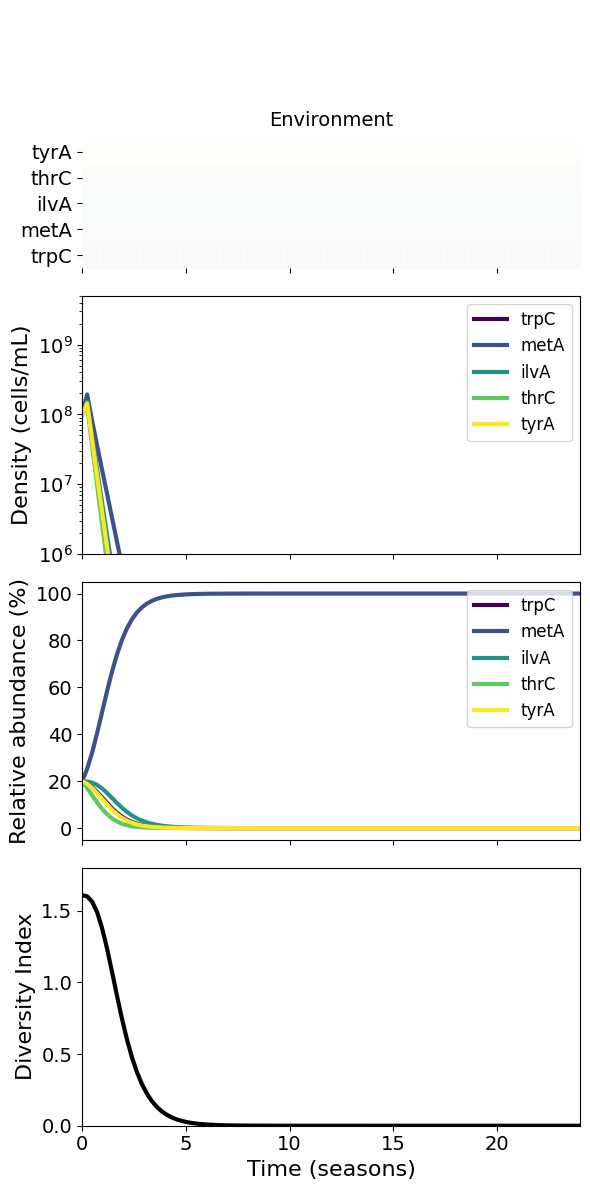

In [70]:

aa_initial_values=A0*np.ones(num_strains)
environmental_conditions_constant = [(aa_initial_values) for _ in range(N)]  # Environmental conditions for each cycle

# Define initial conditions
num_strains = len(strains_parameters)  # Number of strains
u0 = [S0] + [Amax] * num_strains  + [B0] * num_strains

# Run the feedback simulation
results_constant_df, resultsT_constant_df = run_simulation(strains_parameters, u0, environmental_conditions_constant, T)

# Calculate the relative proportion
relative_proportion = calculate_relative_proportion(results_constant_df)
endpoint_relative_proportion = relative_proportion.iloc[-1]
print('Final proportion: %s' % endpoint_relative_proportion)

# Plot the simulation results
#plot_simulation(strains_parameters, results_constant_df, N, environmental_conditions)
plot_simulation(strains_parameters, resultsT_constant_df, N, environmental_conditions_constant)


#plot_diversity([resultsT_constant_df])